In [1]:
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF

# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

KTF.set_session(sess)

Using TensorFlow backend.


In [2]:
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys


def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str):
    """
    Loads input data from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)
#     print(tx.shape)
#     print(len(ty))
    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
#     print(test_idx_range)
#     print(len(test_idx_range))
#     print(x.shape)
#     print(len(y))
#     print(allx.shape)
#     print(len(ally))
#     print(tx.shape)
#     print(len(ty))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, labels


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return sparse_to_tuple(t_k)


In [3]:
adj = load_data('pubmed')[0]

In [4]:
import networkx as nx
nx.draw(adj)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
a = load_data('citeseer')[0].toarray().tolist()
count = 0
for i in a:
    
    if 1 in i:
        count += 1
        print(i.index(1))
print(count)

In [ ]:
autoencoder.layers

In [ ]:
from keras.layers import Input, Dense  
from keras.layers.normalization import BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
import numpy as np  
import matplotlib.pyplot as plt  
# import pandas as pd
import matplotlib as mpl
# import matplotlib.pyplot as plt
# import numpy as np
# from numpy import *
data = np.load('/home/lifuzhen/Dataset/mnist.npz')
x_train, x_test = data['x_train'], data['x_test']
  
x_train = x_train.astype('float32') / 255.  
x_test = x_test.astype('float32') / 255.  
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))  
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))  
print(x_train.shape)  
print(x_test.shape)  
  
encoding_dim = 256  
input_img = Input(shape=(784,))  
  
encoded = Dense(encoding_dim, activation='sigmoid',use_bias=False) 
encoded1 = encoded(input_img)
encoded1 = BatchNormalization(axis=-1)(encoded1)

# decoded = Lambda(lambda x: K.dot(x,K.variable(np.transpose(encoded.get_weights()[0]),dtype='float32')))(encoded1)
decoded = Dense(784, activation='sigmoid',use_bias=False)
decoded1 = decoded(encoded1)  
  
autoencoder = Model(inputs=input_img, outputs=decoded1)  
encoder = Model(inputs=input_img, outputs=encoded1)  
  
encoded_input = Input(shape=(encoding_dim,))  
decoder_layer = autoencoder.layers[-1]  
  
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))  
  
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')  
  
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256,   
                shuffle=True, validation_data=(x_test, x_test))  
  
encoded_imgs = encoder.predict(x_test)  
decoded_imgs = decoder.predict(encoded_imgs)  
decoded_imgs = autoencoder.predict(x_test)  
n = 10  # how many digits we will display  
plt.figure(figsize=(20, 4))  
for i in range(n):  
    ax = plt.subplot(2, n, i + 1)  
    plt.imshow(x_test[i].reshape(28, 28))  
    plt.gray()  
    ax.get_xaxis().set_visible(False)  
    ax.get_yaxis().set_visible(False)  
  
    ax = plt.subplot(2, n, i + 1 + n)  
    plt.imshow(decoded_imgs[i].reshape(28, 28))  
    plt.gray()  
    ax.get_xaxis().set_visible(False)  
    ax.get_yaxis().set_visible(False)  
plt.show()  

In [ ]:
from keras.layers import Input, Dense  ,Dot ,Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF

# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

KTF.set_session(sess)
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj + sp.eye(adj.shape[0]))
# feature = load_data(dataset)[1]
# # original_train, original_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
# x_train, x_test = adj_normalize.dot(adj_normalize).dot(feature)[load_data(dataset)[5]], adj_normalize.dot(adj_normalize).dot(feature)[load_data(dataset)[7]]
# y_train = load_data(dataset)[2][load_data(dataset)[5]].tolist()
# sample_num = 4 ##随机采样数
# margin = 10  ##类间距
########一层#############
# encoding_dim = 1024
# input_node = Input(shape=(3703,))  
# a_input_node = Input(shape=(3703,)) ##anchor
# p_input_node = Input(shape=(3703,))  ##positive
# n_input_node = Input(shape=(3703,))  ##negative

# encoded = Dense(encoding_dim, activation='sigmoid')(input_node)  
# decoded = Dense(3703, activation='sigmoid')(encoded)  

# autoencoder = Model(inputs=input_node, outputs=decoded)  
# encoder = Model(inputs=input_node, outputs=encoded)    

# encoded_input = Input(shape=(encoding_dim,))  
# decoder_layer = autoencoder.layers[-1]  
# decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input)) 
# a_encoded = autoencoder.layers[-2](a_input_node)
# p_encoded = autoencoder.layers[-2](p_input_node)
# n_encoded = autoencoder.layers[-2](n_input_node)
 
# triplet = Lambda(lambda x: K.maximum(K.sum(K.square(x[0]-x[1])) - K.sum(K.square(x[0]-x[2]))+ margin,0))([a_encoded,p_encoded,n_encoded])
# triplet_model = Model(inputs= [a_input_node,p_input_node,n_input_node], outputs= triplet)
# triplet_model.compile(optimizer='Adam', loss=lambda y_true,y_pred: y_pred)
# autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

#########两层###################
# encoding_dim_1 = 1024
# encoding_dim_2 = 1024
# input_node = Input(shape=(3703,))  
# a_input_node = Input(shape=(3703,)) ##anchor
# p_input_node = Input(shape=(3703,))  ##positive
# n_input_node = Input(shape=(3703,))  ##negative

# encoded_1 = Dense(encoding_dim_1, activation='sigmoid')(input_node)  
# encoded_2 = Dense(encoding_dim_2, activation='relu')(encoded_1)  
# decoded = Dense(3703, activation='sigmoid')(encoded_2)  

# autoencoder = Model(inputs=input_node, outputs=decoded)  
# encoder = Model(inputs=input_node, outputs=encoded_2)    

# encoded_input = Input(shape=(encoding_dim_2,))  
# decoder_layer = autoencoder.layers[-1]  
# decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input)) 
# a_encoded = autoencoder.layers[-2](autoencoder.layers[-3](a_input_node))
# p_encoded = autoencoder.layers[-2](autoencoder.layers[-3](p_input_node))
# n_encoded = autoencoder.layers[-2](autoencoder.layers[-3](n_input_node))
 
# triplet = Lambda(lambda x: K.maximum(K.sum(K.square(x[0]-x[1])) - K.sum(K.square(x[0]-x[2]))+ margin,0))([a_encoded,p_encoded,n_encoded])
# triplet_model = Model(inputs= [a_input_node,p_input_node,n_input_node], outputs= triplet)
# triplet_model.compile(optimizer='Adam', loss=lambda y_true,y_pred: y_pred)
# autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

############# 两层：A(AXW)W #################

# def embedding(x):
#     x_new = []
#     for i in range(len(x)):
#         x_new.append(encoder_1.predict(x[i]))
#     sp.vstack(x_new)
#     return x_new
dataset = 'cora'  #citeseer   cora  pubmed
####D^(-0.5)(A+I)D^(-0.5)
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj + sp.eye(adj.shape[0]))
# adj_normalize_tf = tf.convert_to_tensor(adj_normalize.toarray(),dtype='float32')
######(I - D^(-0.5)AD^(-0.5))^(-1)
adj = load_data(dataset)[0]
adj_normalize = normalize_adj(adj)
adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.99*adj_normalize.toarray())
adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')
feature = load_data(dataset)[1]
# original_train, original_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
# x_train, x_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
y_train = load_data(dataset)[2][load_data(dataset)[5]].tolist()


########存每一类的索引#######
C = []
for i in range(load_data(dataset)[2].shape[1]):
    C.append([])
    
for j in range(0,load_data(dataset)[2].shape[1]):
   
    count = 0
    for i in y_train:
        if i.index(1) == j:
            C[j].append(count)
        count += 1
        
        
sample_num = 4 ##随机采样数
margin = 20##类间距 citeseer 50 cora 10 pubmed
####citeseer########
# encoding_dim_1 = 2048
# encoding_dim_2 = 1024
####cora #######
encoding_dim_1 = 1024
encoding_dim_2 = 1024
######pubmed#####
# encoding_dim_1 = 8
# encoding_dim_2 = 8

order_0 = Input(shape=(feature.shape[1],)) 

def graph_convex(x):
    x1 = K.dot(adj_normalize_tf,x)
    return x1


order_1 = Lambda(function=graph_convex)(order_0)
encoded_1 = Dense(encoding_dim_1, activation='relu')(order_1)  
# encoder_1 = Model(inputs=input_node,outputs= encoded_1)

order_2 = Lambda(function= graph_convex)(encoded_1)
encoded_2 = Dense(encoding_dim_2, activation='relu')(order_2)  

decoded = Dense(feature.shape[1], activation='sigmoid')(encoded_2)  

autoencoder = Model(inputs=order_0, outputs=decoded)  
encoder = Model(inputs=order_0, outputs=encoded_2)    

encoded_input = Input(shape=(encoding_dim_2,))  
decoder_layer = autoencoder.layers[-1]  
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input)) 
encoded_train = encoder(order_0)

# def cluster_metric(x):
#     L = K.variable(0,dtype='float32')
# #     print(x)
#     for i in range(6):
#         for j in range(i+1,6):
# #             print(center_j)
# #             print(D_center)
#             L = tf.subtract(L , K.sum(K.square(K.mean(K.gather(x,C[i]),0)- K.mean(K.gather(x,C[j]),0))))
# #             print(inter_sum)

#         for j in C[i]:
#             L = tf.add(L , K.sum(K.square(K.gather(x,j) - K.mean(K.gather(x,C[i]),0))))
# #             print(D_sample_center)
#     return  L

# def cluster_metric(x):
#     inter_sum = K.variable(0,dtype='float32')
#     intra_sum = K.variable(0,dtype='float32')
# #     print(x)
#     for i in range(6):
#         center_i = K.mean(K.gather(x,C[i]),0)
#         for j in range(i+1,6):
#             center_j = K.mean(K.gather(x,C[j]),0)
# #             print(center_j)
#             D_center = K.sum(K.square(center_i-center_j))
# #             print(D_center)
#             inter_sum = inter_sum + D_center
# #             print(inter_sum)

#         for j in C[i]:
#             D_sample_center = K.sum(K.square(K.gather(x,j) - center_i))
# #             print(D_sample_center)
#             intra_sum = intra_sum + D_sample_center
#     L = K.relu(0.05 * intra_sum - 0.95 * inter_sum + margin)
#     return  L
# def cluster_metric(x):
#     L = K.variable(0,dtype='float32')
#     L_intra = K.variable(0,dtype='float32')
#     L_inter = K.variable(0,dtype='float32')
# #     print(x)
#     for i in range(6):
#         for m in C[i]:
#             L_intra = L_intra + K.mean(K.log(1+K.sum(K.square(K.gather(x,m)-K.gather(x,C[i])),1)))/6.0
# #             print(L_intra)
#             for j in range(i+1,6):
#                 L_inter = L_inter + K.mean(K.log(1+K.sum(K.square(K.gather(x,m)-K.gather(x,C[j])),1)))/15.0
#     L = L_intra - L_inter
                
                

#     return  L

def cluster_metric(x):
    L = K.variable(0,dtype='float32')
    L_intra = K.variable(0,dtype='float32')
    L_inter = K.variable(0,dtype='float32')
#     print(x)
    for i in range(load_data(dataset)[2].shape[1]):
        for m in C[i]:
            L_intra = L_intra + K.mean(K.relu(K.sum(K.square(K.gather(x,m)-K.gather(x,C[i])),1) - margin ))
#             print(L_intra)
            for j in range(i+1,load_data(dataset)[2].shape[1]):
                L_inter = L_inter + K.mean(K.relu( margin - K.sum(K.square(K.gather(x,m)-K.gather(x,C[j])),1)))
    L = L_intra + L_inter
                
                

    return  L
    
Loss = Lambda(function=cluster_metric)(encoded_train)
triplet_model = Model(inputs= order_0, outputs= Loss)
triplet_model.compile(optimizer='Adam', loss=lambda y_true,y_pred: y_pred)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')
# C0 = []
# C1 = []  ##target and positive
# C2 = []  ##negative
# C3 = []
# C4 = []
# C5 = []
# C = [C0,C1,C2,C3,C4,C5]
# for j in range(0,6):
   
#     count = 0
#     for i in y_train:
#         if i.index(1) == j:
#             C[j].append(x_train[count])
#         count += 1
# for m in tqdm(range(0,10)):
#     for j in range(0,6):
# #         C1 = []  ##target and positive
# #         C2 = []  ##negative
# #         C = [C1,C2]
# #         count = 0
# #         for i in y_train:
# #             if i.index(1) == j:
# #                 C1.append(x_train[count])
# #             if i.index(1) != j:
# #                 C2.append(x_train[count])
# #             count += 1
# #         print(x_train.shape)  
# #         print(x_test.shape)  
#         autoencoder.fit(x_train, x_train, epochs=10, batch_size=32,   
#                         shuffle=True, validation_data=(x_test, x_test))
#         for k in range(6):
#             if j != k:
#                 a = sp.vstack(sample(C[j],sample_num))
#                 p = sp.vstack(sample(C[j],sample_num))
#                 n = sp.vstack(sample(C[k],sample_num))
# #                 triplet_model.fit([sp.vstack(sample(C[j],sample_num)),sp.vstack(sample(C[j],sample_num)),sp.vstack(sample(C[k],sample_num))],
# #                               np.zeros((sample_num,1)), epochs=20, batch_size=2,shuffle=True)
#                 triplet_model.fit([a,p,n],
#                               np.zeros((sample_num,1)), epochs=20, batch_size=2,shuffle=True)

for m in tqdm(range(0,30)):
#         C1 = []  ##target and positive
#         C2 = []  ##negative
#         C = [C1,C2]
#         count = 0
#         for i in y_train:
#             if i.index(1) == j:
#                 C1.append(x_train[count])
#             if i.index(1) != j:
#                 C2.append(x_train[count])
#             count += 1
#         print(x_train.shape)  
#         print(x_test.shape)  
        autoencoder.fit(feature, feature, epochs=10,batch_size=feature.shape[0],   
                        shuffle=False)
#                 a = sp.vstack(sample(C[j],sample_num))
#                 p = sp.vstack(sample(C[j],sample_num))
#                 n = sp.vstack(sample(C[k],sample_num))
#                 triplet_model.fit([sp.vstack(sample(C[j],sample_num)),sp.vstack(sample(C[j],sample_num)),sp.vstack(sample(C[k],sample_num))],
#                               np.zeros((sample_num,1)), epochs=20, batch_size=2,shuffle=True)
        triplet_model.fit(feature,np.zeros((feature.shape[0],1)),batch_size=feature.shape[0], epochs=50,shuffle=False)
#         print(triplet_model.predict(feature,batch_size=3327))


          

encoded_node = encoder.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]




from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(encoded_node)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

# 支持向量机+GBDT+RF+KNN

In [16]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import scipy.io as sio
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
dataset = 'pubmed'
SDNE = sio.loadmat("/home/lifuzhen/SDNE/result/pubmed-Thu-Nov--1-16:33:33-2018/embedding.mat")['embedding']
trainX , trainY = SDNE[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = SDNE[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

SVC = SVC(C=0.5,kernel='rbf')
GBDT = GradientBoostingClassifier(n_estimators=8)
RF = RandomForestClassifier()
KNN = KNeighborsClassifier(n_neighbors=6)

SVC.fit(trainX, trainY)
GBDT.fit(trainX, trainY)
RF.fit(trainX, trainY)
KNN.fit(trainX,trainY)

pred_SVC = SVC.predict(testX)
pred_GBDT = GBDT.predict(testX)
pred_RF = RF.predict(testX)
pred_KNN = KNN.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

SVC_auc：0.570000
GBDT_auc：0.387000
RF_auc：0.415000
KNN_auc:0.512000


SVC_auc：0.451000
GBDT_auc：0.661000
RF_auc：0.710000
KNN_auc:0.689000


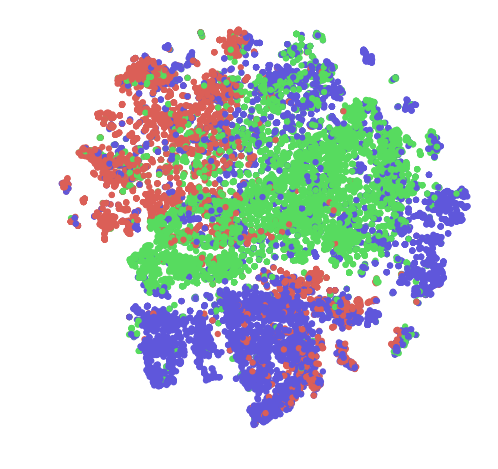

mean:0.689000
std:0.000000


In [11]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
#     print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
acc = []
for n in range(1):
    dataset = 'pubmed'  #citeseer   cora  pubmed
    adj = load_data(dataset)[0]
    adj_normalize = normalize_adj(adj + sp.eye(adj.shape[0])).toarray()

    adj = load_data(dataset)[0]
    adj_normalize = normalize_adj(adj)
    adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.95*adj_normalize.toarray())
    feature = load_data(dataset)[1].toarray()

    trainX , trainY = np.dot(adj_normalize, feature)[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = np.dot(adj_normalize, feature)[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    svc = SVC(C=3,kernel='rbf')#cora 1.7 citeseer 3
    gbdt = GradientBoostingClassifier(n_estimators=8)
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()

    svc.fit(trainX, trainY)
    gbdt.fit(trainX, trainY)
    rf.fit(trainX, trainY)
    knn.fit(trainX,trainY)

    pred_SVC = svc.predict(testX)
    pred_GBDT = gbdt.predict(testX)
    pred_RF = rf.predict(testX)
    pred_KNN = knn.predict(testX)

    auc_SVC = metrics.accuracy_score(testY , pred_SVC)
    auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
    auc_RF = metrics.accuracy_score(testY , pred_RF)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    acc.append(auc_KNN)
    
    print('SVC_auc：%f'%auc_SVC)
    print('GBDT_auc：%f'%auc_GBDT)
    print('RF_auc：%f'%auc_RF)
    print('KNN_auc:%f'%auc_KNN)
    proj1 = TSNE(random_state=123).fit_transform(np.dot(adj_normalize, feature))

    y = onehot2index(load_data(dataset)[8])
    scatter(proj1, y)
    plt.show()
print('mean:%f'%np.mean(acc))
print('std:%f'%np.std(acc))

In [ ]:
load_data(dataset)[8].shape

# 迹约束对比实验

In [8]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.patheffects as PathEffects
K.clear_session()
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
#     print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)

KTF.set_session(sess)

dataset = 'pubmed'  #citeseer   cora  pubmed
acc = []
for reg in range(5):
    maxi = 0
    feature = load_data(dataset)[1].toarray()
    ####自带邻接矩阵
    adj = load_data(dataset)[0]
    adj_normalize = np.diag(np.sum(adj.toarray(), axis= -1)) - adj.toarray()
    adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')
    # #####逼近式
    # alpha = 0.9  ###局部强度
    # adj = load_data(dataset)[0]
    # adj = adj.astype('float32')
    # adj_normalize = normalize_adj(adj)
    # adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - alpha*adj_normalize.toarray())
    # # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)
    # adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')

    encoding_dim_1 = 256
    e = 5e-4 ###cora: 3e-2 citeseer:8e-2  pubmed: 5e-4
    t = 1.0  ##高斯核系数
    epoch = 500 ###cora: 300 citeseer:250  pubmed:500
    time = []
#     acc = []
    # rate = 0.1  ###相似度矩阵学习率
    for n in tqdm(range(1)):
        input_1 = Input(shape=(feature.shape[1],)) 

        encoded = Dense(encoding_dim_1, activation='sigmoid', use_bias=True)(input_1)  
        encoded1 = BatchNormalization(axis = -1)(encoded)

        decoded = Dense(feature.shape[1], activation='sigmoid', use_bias=True)(encoded1)
    #     decoded = BatchNormalization(axis = -1)(decoded)

        autoencoder = Model(inputs=input_1, outputs=decoded)  
        encoder = Model(inputs=input_1, outputs=encoded)    

        def myloss(y_true, y_pred):
            recon = K.mean(K.square(y_true - y_pred), axis= -1)
            trace = K.sum(K.dot(K.dot(K.transpose(encoded), adj_normalize_tf), encoded) * K.eye(encoding_dim_1))/encoding_dim_1
            return recon + e*trace

        adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        autoencoder.compile(optimizer = adam, loss = myloss)
        autoencoder.fit(feature, feature, epochs=epoch,batch_size=feature.shape[0],shuffle=False,verbose=0)

    #     encoded_node_1 = encoder.predict(feature,batch_size=feature.shape[0])

    #     proj = TSNE(random_state=123).fit_transform(encoded_node_1)

    #     y = onehot2index(load_data(dataset)[8])
    #     scatter(proj, y)
    #     plt.show()

        trainX , trainY = encoder.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
        testX, testY = encoder.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

        knn = KNeighborsClassifier()
        knn.fit(trainX,trainY)
        pred_KNN = knn.predict(testX)
        auc_KNN = metrics.accuracy_score(testY , pred_KNN)
        print(auc_KNN)
        maxi = max(maxi, auc_KNN)
        feature = encoder.predict(feature,batch_size=feature.shape[0])
        encoding_dim_1 = max(int(encoding_dim_1/2), 512)
    #     epoch = max(int(epoch/2), 100)
    #     epoch = 100
        if encoding_dim_1 > 512:
            e = e/2/2
            
    acc.append(maxi)
print('mean:%f'%np.mean(acc))
print('std:%f'%np.std(acc))
#         print('KNN_auc:%f'%auc_KNN)

#         time.append(n)
#         acc.append(auc_KNN)
#         plt.plot(time, acc, 'b')
#         plt.show()
        ####邻接矩阵
    #     adj = np.zeros([feature.shape[0],feature.shape[0]])
    #     for i in range(feature.shape[0]):
    #         adj[i] = np.exp(-np.sum(np.square(proj - proj[i]) ,axis=1))

    #     adj = adj - np.eye(adj.shape[1])

    #     adj_normalize = normalize_adj(adj) 
    #     adj_normalize_tf = tf.convert_to_tensor(adj_normalize.toarray(), dtype='float32')

        

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
acc

In [ ]:
np.sort(-feature[1]).tolist()

# Concat传递方案

In [ ]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF
K.clear_session()
# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)

KTF.set_session(sess)

dataset = 'pubmed'  #citeseer   cora  pubmed
acc = []
for n in range(5):
    feature = load_data(dataset)[1].toarray()
    # original_train, original_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
    # x_train, x_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
    y_train = load_data(dataset)[2][load_data(dataset)[5]].tolist()
    ####自带邻接矩阵
    adj = load_data(dataset)[0]
    adj_normalize = adj
    adj_normalize_tf = tf.convert_to_tensor(adj_normalize.toarray(),dtype='float32')
    #####逼近式
    # alpha = 0.99
    # adj = load_data(dataset)[0]
    # adj_normalize = normalize_adj(adj)
    # adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
    # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

    # adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')
    encoding_dim_1 = 512
    encoding_dim_2 = 256

    order_0 = Input(shape=(feature.shape[1],)) 

    def graph_convex(x):
        x1 = K.concatenate([adj_normalize_tf,x], axis = -1)
        return x1

    ###########不对称
    order_1 = Lambda(function=graph_convex)(order_0)
    encoded_1 = Dense(encoding_dim_1, activation='relu', use_bias=True)(order_1)  
    # encoded_1 = Dropout(0.5)(encoded_1)
    # encoded_1 = BatchNormalization(axis = -1)(encoded_1)

    order_2 = Lambda(function= graph_convex)(encoded_1)
    encoded_2 = Dense(encoding_dim_2, activation='relu', use_bias=True)(order_2)  
    # encoded_2 = Dropout(0.5)(encoded_2)
    # encoded_2 = BatchNormalization(axis = -1)(encoded_2)

    order_3 = Lambda(function= graph_convex)(encoded_2)
    decoded_1 = Dense(encoding_dim_1, activation='relu', use_bias=True)(order_3)  
    # decoded_1 = Dropout(0.5)(decoded_1)
    # decoded_1 = BatchNormalization(axis = -1)(decoded_1)

    order_4 = Lambda(function= graph_convex)(decoded_1)
    decoded_2 = Dense(feature.shape[1], activation='relu', use_bias=True)(order_4)  
    # decoded_2 = BatchNormalization(axis = -1)(decoded_2)
    autoencoder = Model(inputs=order_0, outputs=decoded_2)  
    encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
    encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
    decoder_1 = Model(inputs=order_0, outputs=decoded_1)


    ########重构loss#################
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
    autoencoder.fit(feature, feature, epochs=100,batch_size=feature.shape[0],shuffle=False)

    encoded_node_1 = encoder_2.predict(feature,batch_size=feature.shape[0])

    proj = TSNE(random_state=123).fit_transform(encoded_node_1)

    y = onehot2index(load_data(dataset)[8])
    scatter(proj, y)
    plt.show()

    trainX , trainY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    knn = KNeighborsClassifier()
    knn.fit(trainX,trainY)
    pred_KNN = knn.predict(testX)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    print('KNN_auc:%f'%auc_KNN)
    acc.append(auc_KNN)
    
print('mean:%f'%np.mean(acc))
print('std:%f'%np.std(acc))

In [ ]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
K.clear_session()

def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)

KTF.set_session(sess)

dataset = 'cora'  #citeseer   cora  pubmed(每层加BN,20,4096)

feature = load_data(dataset)[1].toarray()
# original_train, original_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
# x_train, x_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
y_train = load_data(dataset)[2][load_data(dataset)[5]].tolist()
####自带邻接矩阵
adj = load_data(dataset)[0]
adj_normalize = adj
adj_normalize_tf = tf.convert_to_tensor(adj_normalize.toarray(),dtype='float32')
#####逼近式
# alpha = 0.99
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj)
# adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

# adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')
encoding_dim_1 = 2048
encoding_dim_2 = 512
feature = np.concatenate([feature, adj.toarray()], axis = -1)
acc = []
for n in range(5):
    order_0 = Input(shape=(feature.shape[1],)) 


    ###########不对称
    encoded_1 = Dense(encoding_dim_1, activation='sigmoid', use_bias=True)(order_0)  
    # encoded_1 = Dropout(0.5)(encoded_1)
    encoded_1 = BatchNormalization(axis = -1)(encoded_1)

    encoded_2 = Dense(encoding_dim_2, activation='sigmoid', use_bias=True)(encoded_1)  
    # encoded_2 = Dropout(0.5)(encoded_2)
    encoded_2 = BatchNormalization(axis = -1)(encoded_2)

    decoded_1 = Dense(encoding_dim_1, activation='sigmoid', use_bias=True)(encoded_2)  
    # decoded_1 = Dropout(0.5)(decoded_1)
    decoded_1 = BatchNormalization(axis = -1)(decoded_1)

    decoded_2 = Dense(feature.shape[1], activation='sigmoid', use_bias=True)(decoded_1)  
    # decoded_2 = BatchNormalization(axis = -1)(decoded_2)
    autoencoder = Model(inputs=order_0, outputs=decoded_2)  
    encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
    encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
    decoder_1 = Model(inputs=order_0, outputs=decoded_1)


    ########重构loss#################
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
    autoencoder.fit(feature, feature, epochs=20,batch_size=feature.shape[0],shuffle=True,verbose=0)

    # encoded_node_1 = encoder_2.predict(feature,batch_size=feature.shape[0])

    # proj = TSNE(random_state=123).fit_transform(encoded_node_1)

    # y = onehot2index(load_data(dataset)[8])
    # scatter(proj, y)
    # plt.show()

    trainX , trainY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    knn = KNeighborsClassifier()
    knn.fit(trainX,trainY)
    pred_KNN = knn.predict(testX)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    print('KNN_auc:%f'%auc_KNN)
    
    acc.append(auc_KNN)
    
print('mean:%f'%np.mean(acc))
print('std:%f'%np.std(acc))

In [ ]:
fig=plt.figure()

# 重构相似度矩阵

In [5]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.patheffects as PathEffects
K.clear_session()
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
#     print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)

KTF.set_session(sess)

dataset = 'cora'  #citeseer   cora  pubmed

feature = load_data(dataset)[1].toarray()
ACC=[0,0,0,0,0]
for i in range(1):
#####逼近式
    alpha = 0.85  ###局部强度
    adj = load_data(dataset)[0].toarray()
    adj = adj.astype('float32')
    adj_normalize = normalize_adj(adj)
    adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - alpha*adj_normalize.toarray())
    # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)
    adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')

    ######penalty of degree
    adj_tf = tf.convert_to_tensor(adj, dtype='float32')
    # C = adj_normalize_tf
    C = adj_tf
    # C = adj_tf + K.dot(adj_tf, adj_tf) - K.dot(adj_tf, adj_tf)*K.eye(feature.shape[0])
    D = K.dot(adj_tf, adj_tf)*K.eye(feature.shape[0])  ##degree matrix
    D_pow = K.pow(D + 1e-10, -1)*K.eye(feature.shape[0])

    D_norm = K.pow(D + 1e-20, -0.5)*K.eye(feature.shape[0]) ####D^-0.5
    W = K.dot(K.dot(D_pow, C), D_pow)
    W = K.dot(K.dot(D_norm, W), D_norm)
    L = K.eye(feature.shape[0]) - W

    encoding_dim_1 = 2048
    encoding_dim_2 = 512
    t = 1.0/4  ##高斯核系数
    rate = 0.1  ###相似度矩阵学习率
    iter_n = []
    acc = []
    # order_0 = Input(shape=(feature.shape[1],)) 

    # def graph_convex(x):
    #     x1 = K.dot(adj_normalize_tf,x)
    #     return x1

    # ###########不对称
    # order_1 = Lambda(function=graph_convex)(order_0)
    # encoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_1)  
    # # encoded_1 = Dropout(0.5)(encoded_1)
    # encoded_1 = BatchNormalization(axis = -1)(encoded_1)

    # order_2 = Lambda(function= graph_convex)(encoded_1)
    # encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(order_2)  
    # # encoded_2 = Dropout(0.5)(encoded_2)
    # encoded_2 = BatchNormalization(axis = -1)(encoded_2)

    # order_3 = Lambda(function= graph_convex)(encoded_2)
    # decoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_3)  
    # # decoded_1 = Dropout(0.5)(decoded_1)
    # decoded_1 = BatchNormalization(axis = -1)(decoded_1)

    # order_4 = Lambda(function= graph_convex)(decoded_1)
    # decoded_2 = Dense(feature.shape[1], activation='tanh', use_bias=True)(order_4)  
    # # decoded_2 = BatchNormalization(axis = -1)(decoded_2)

    # autoencoder = Model(inputs=order_0, outputs=decoded_2)  
    # encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
    # encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
    # decoder_1 = Model(inputs=order_0, outputs=decoded_1)

    # adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)




    for n in tqdm(range(20)):
        D_vect = np.sqrt(np.sum(adj,axis=0))
        order_0 = Input(shape=(feature.shape[1],)) 

        def graph_convex(x):
            x1 = K.dot(adj_normalize_tf,x)
            return x1

    #     order_1 = Lambda(function=graph_convex)(order_0)
    #     encoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_1)  
    # #     encoded_1 = Dropout(0.5)(encoded_1)
    #     encoded_1 = BatchNormalization(axis = -1)(encoded_1)
    ###七层############
    #     order_2 = Lambda(function= graph_convex)(order_0)
    #     order_2 = BatchNormalization(axis = -1)(order_2)
    #     encoded_22 = Dense(2048, activation='tanh', use_bias=True)(order_2)  
    # #     encoded_2 = Dropout(0.5)(encoded_2)
    # #     encoded_22 = BatchNormalization(axis = -1)(encoded_22)

    #     order_2 = Lambda(function= graph_convex)(encoded_22)
    #     order_2 = BatchNormalization(axis = -1)(order_2)
    #     encoded_22 = Dense(1024, activation='tanh', use_bias=True)(order_2)  
    # #     encoded_2 = Dropout(0.5)(encoded_2)
    # #     encoded_22 = BatchNormalization(axis = -1)(encoded_22)

    #     order_2 = Lambda(function= graph_convex)(encoded_22)
    #     order_2 = BatchNormalization(axis = -1)(order_2)
    #     encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(order_2)  
    # #     encoded_2 = Dropout(0.5)(encoded_2)
    # #     encoded_2 = BatchNormalization(axis = -1)(encoded_22)

    # #     order_3 = Lambda(function= graph_convex)(encoded_22)
    # #     decoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_3)  
    # # #     decoded_1 = Dropout(0.5)(decoded_1)
    # #     decoded_1 = BatchNormalization(axis = -1)(decoded_1)

    #     order_4 = Lambda(function= graph_convex)(encoded_2)
    #     order_4 = BatchNormalization(axis = -1)(order_4)
    #     decoded_2 = Dense(1024, activation='tanh', use_bias=True)(order_4)  
    # #     decoded_2 = BatchNormalization(axis = -1)(decoded_2)

    #     order_4 = Lambda(function= graph_convex)(decoded_2)
    #     order_4 = BatchNormalization(axis = -1)(order_4)
    #     decoded_2 = Dense(2048, activation='tanh', use_bias=True)(order_4)  
    # #     decoded_2 = BatchNormalization(axis = -1)(decoded_2)

    #     order_4 = Lambda(function= graph_convex)(decoded_2)
    #     order_4 = BatchNormalization(axis = -1)(order_4)
    #     decoded_2 = Dense(feature.shape[1], activation='sigmoid', use_bias=True)(order_4)  
    #     decoded_2 = BatchNormalization(axis = -1)(decoded_2)
        ###########不对称
        order_1 = Lambda(function=graph_convex)(order_0)
    #     order_1 = BatchNormalization(axis = -1)(order_1)
        encoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_1)  
    #     encoded_1 = Dropout(0.5)(encoded_1)
        encoded_1 = BatchNormalization(axis = -1)(encoded_1)

        order_2 = Lambda(function= graph_convex)(encoded_1)
    #     order_2 = BatchNormalization(axis = -1)(order_2)
        encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(order_2)  
    #     encoded_2 = Dropout(0.5)(encoded_2)
        encoded_22 = BatchNormalization(axis = -1)(encoded_2)

        order_3 = Lambda(function= graph_convex)(encoded_22)
    #     order_3 = BatchNormalization(axis = -1)(order_3)
        decoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_3)  
    #     decoded_1 = Dropout(0.5)(decoded_1)
        decoded_1 = BatchNormalization(axis = -1)(decoded_1)

        order_4 = Lambda(function= graph_convex)(decoded_1)
    #     order_4 = BatchNormalization(axis = -1)(order_4)
        decoded_2 = Dense(feature.shape[1], activation='sigmoid', use_bias=True)(order_4)  
    #     decoded_2 = BatchNormalization(axis = -1)(decoded_2)

        def myloss(y_true, y_pred, e= 1e-5):
            recon = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
            trace = K.sum(K.dot(K.dot(K.transpose(encoded_2), L), encoded_2) * K.eye(encoding_dim_2))/encoding_dim_2
    #         orth = K.mean(K.square(K.dot(K.dot(K.transpose(encoded_2), D), encoded_2) - K.eye(encoding_dim_2)))
            return recon + e*trace

        autoencoder = Model(inputs=order_0, outputs=decoded_2)  
    #     encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
        encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
    #     decoder_1 = Model(inputs=order_0, outputs=decoded_1)

        adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        autoencoder.compile(optimizer=adam, loss=myloss)
        autoencoder.fit(feature, feature, epochs=300,batch_size=feature.shape[0],shuffle=False,verbose=1)

        encoded_node_1 = encoder_2.predict(feature,batch_size=feature.shape[0])

        proj3 = TSNE(random_state=123,perplexity=30,early_exaggeration=12,init='random').fit_transform(encoded_node_1)

        y = onehot2index(load_data(dataset)[8])
    #     plt.subplot(133)
        scatter(proj3, y)
    #     plt.savefig('/home/lifuzhen/gcn/visulization.png')
        plt.show()

        trainX , trainY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
        testX, testY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

        knn = KNeighborsClassifier()
        knn.fit(trainX,trainY)
        pred_KNN = knn.predict(testX)
        auc_KNN = metrics.accuracy_score(testY , pred_KNN)
        print('KNN_auc:%f'%auc_KNN)
        iter_n.append(n)
        acc.append(auc_KNN)
        plt.plot(iter_n, acc, 'b')
        plt.show()

        ###高斯核邻接矩阵t-sne

    #     adj_learn = np.zeros([feature.shape[0],feature.shape[0]])
    #     for i in range(feature.shape[0]):
    #         adj_learn[i] = np.exp(-np.sum(np.square(proj - proj[i])/2.0/t/t ,axis=1))

#         ###高斯核邻接矩阵embedding
        adj_learn = np.zeros([feature.shape[0],feature.shape[0]])
        for i in range(feature.shape[0]):
            adj_learn[i] = np.exp(-np.mean(     np.transpose(np.transpose(np.square(encoded_node_1 - encoded_node_1[i]))*D_vect)*D_vect[i]/t ,axis=1       ))
                ###局部密度高斯核邻接矩阵embedding
#         adj_learn = np.zeros([feature.shape[0],feature.shape[0]])
#         for i in range(feature.shape[0]):
#             for j in range(feature.shape[0]):
#                 adj_learn[i][j] = np.exp(-np.mean(np.square(encoded_node_1[i] - encoded_node_1[j])*D_vect[i]*D_vect[j]/t))

    #     ####sigmoid核
    #     adj_learn = np.zeros([feature.shape[0],feature.shape[0]])
    #     for i in range(feature.shape[0]):
    #         adj_learn[i] = 2.0/(1 + np.exp(np.sum(np.square(encoded_node_1 - encoded_node_1[i])/2.0/t/t ,axis=1)))

        adj_learn = adj_learn - np.eye(adj_learn.shape[1])
        adj_delta = adj_learn - adj
    # #     cmp = np.abs(adj_delta)
    # # #     index_keep = np.where(cmp >= 0.5)
    # #     index_alter = np.where(cmp < 0.7)
    # #     adj[index_alter] = adj_learn[index_alter]
    # #     index_keep = np.where(adj_delta >= 0.5 or adj_delta <= -0.5)
        margin = 0.4
    #     delta = 0.01
        index_alter_P = np.where((0 < adj_delta)&(adj_delta < margin))
        index_alter_N = np.where((-margin < adj_delta)& (adj_delta< 0))
        adj[index_alter_P] += adj_delta[index_alter_P]/2.0
        adj[index_alter_N] += adj_delta[index_alter_N]/2.0
#         adj[index_alter_P] += 0.01
#         adj[index_alter_N] -= 0.01

    #     model_metric = keras.Sequential()
    #     model_metric.add(Dense(512, activation='sigmoid', use_bias=True, input_dim = 512))
    #     model_metric.add(Dense(1024, activation='sigmoid', use_bias=True))
    #     model_metric.add(Dense(feature.shape[0], activation='sigmoid', use_bias=True))
    #     model_metric.compile(optimizer='adam', loss='binary_crossentropy')
    #     model_metric.fit(encoded_node_1, adj, epochs=500, batch_size=256, shuffle=True, verbose=1)

    #     adj = model_metric.predict(encoded_node_1,batch_size=encoded_node_1.shape[0])
    #     adj = (1-rate)*adj + rate*(adj_learn-np.eye(adj_learn.shape[1]))
        adj_normalize = normalize_adj(adj) ######rate or (1-rate)&rate
        adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - alpha*adj_normalize.toarray())
        adj_normalize_tf = tf.convert_to_tensor(adj_normalize, dtype='float32')
    #     adj_tf = tf.convert_to_tensor(adj, dtype='float32')
    #     C = adj_tf + K.dot(adj_tf, adj_tf) - K.dot(adj_tf, adj_tf)*K.eye(feature.shape[0])
    #     D = K.dot(adj_tf, adj_tf)*K.eye(feature.shape[0])  ##degree matrix
    #     D_pow = K.pow(D + 1e-10, -1)*K.eye(feature.shape[0])

    #     D_norm = K.pow(D + 1e-20, -0.5)*K.eye(feature.shape[0]) ####D^-0.5
    #     W = K.dot(K.dot(D_pow, C), D_pow)
    #     W = K.dot(K.dot(D_norm, W), D_norm)
    #     L = K.eye(feature.shape[0]) - W

    print('最高准确率：%f'%max(acc))
    print('平均准确率：%f'%(sum(acc)/len(acc)))
    ACC += acc


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/300


ValueError: GraphDef cannot be larger than 2GB.


  0%|          | 0/21 [00:00<?, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/lifuzhen/virtual_pytorch_py3.5/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/lifuzhen/virtual_pytorch_py3.5/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



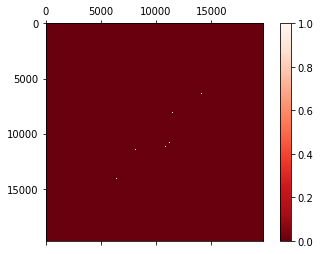

Epoch 1/50
19717/19717 [==============================] - 8s 386us/step - loss: 3.4687
Epoch 2/50
19717/19717 [==============================] - 0s 24us/step - loss: 3.2644
Epoch 3/50
19717/19717 [==============================] - 0s 24us/step - loss: 2.9039
Epoch 4/50
19717/19717 [==============================] - 1s 26us/step - loss: 2.5544
Epoch 5/50
19717/19717 [==============================] - 1s 26us/step - loss: 2.3002
Epoch 6/50
19717/19717 [==============================] - 1s 26us/step - loss: 2.1332
Epoch 7/50
19717/19717 [==============================] - 1s 26us/step - loss: 1.9470
Epoch 8/50
19717/19717 [==============================] - 0s 25us/step - loss: 1.7884
Epoch 9/50
19717/19717 [==============================] - 1s 26us/step - loss: 1.6660
Epoch 10/50
19717/19717 [==============================] - 0s 25us/step - loss: 1.5382
Epoch 11/50
19717/19717 [==============================] - 1s 26us/step - loss: 1.4041
Epoch 12/50
19717/19717 [==========================

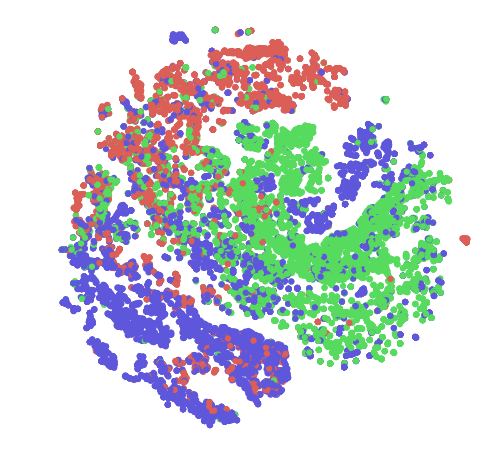

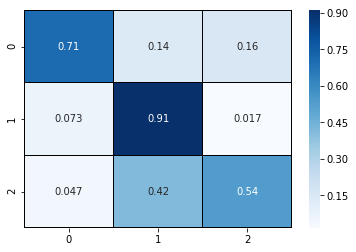

KNN_auc:0.721000


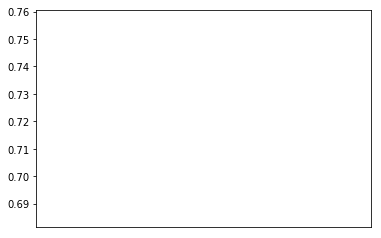

  5%|▍         | 1/21 [13:14<4:24:59, 794.99s/it]

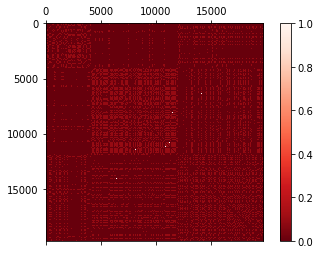

Epoch 1/3
19717/19717 [==============================] - 6s 279us/step - loss: 0.2663
Epoch 2/3
19717/19717 [==============================] - 0s 24us/step - loss: 2.3108
Epoch 3/3
19717/19717 [==============================] - 0s 25us/step - loss: 0.9068


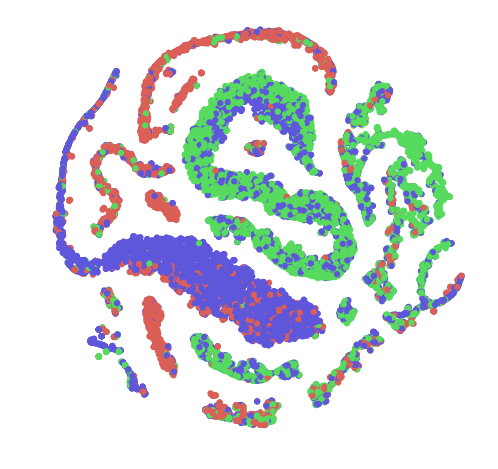

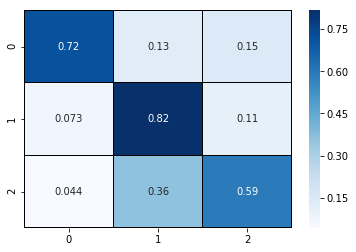

KNN_auc:0.708000


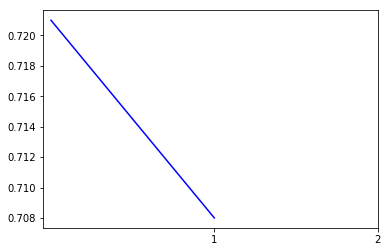

 10%|▉         | 2/21 [25:25<4:01:33, 762.84s/it]

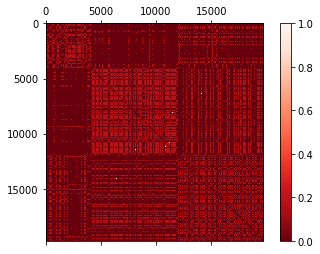

Epoch 1/3
19717/19717 [==============================] - 6s 289us/step - loss: 0.7514
Epoch 2/3
19717/19717 [==============================] - 0s 25us/step - loss: 0.8612
Epoch 3/3
19717/19717 [==============================] - 1s 26us/step - loss: 1.2257


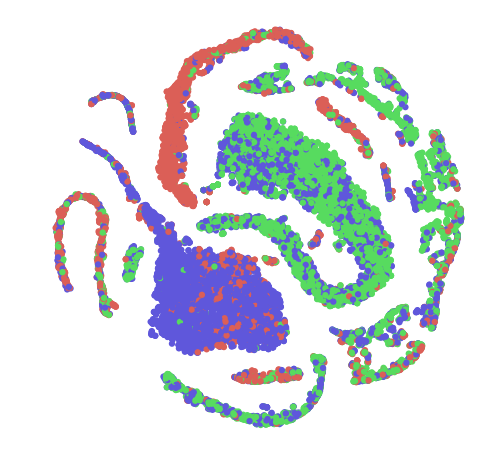

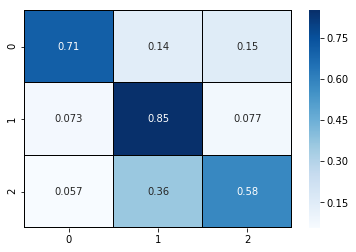

KNN_auc:0.715000


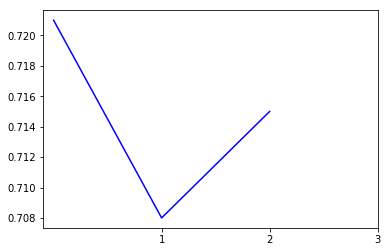

 14%|█▍        | 3/21 [37:51<3:47:09, 757.17s/it]

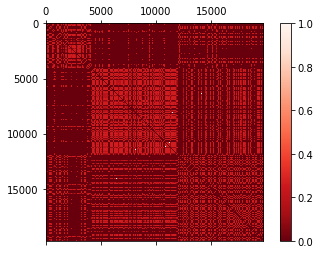

Epoch 1/3
19717/19717 [==============================] - 6s 286us/step - loss: 0.7364
Epoch 2/3
19717/19717 [==============================] - 1s 26us/step - loss: 1.5322
Epoch 3/3
19717/19717 [==============================] - 0s 25us/step - loss: 1.2684


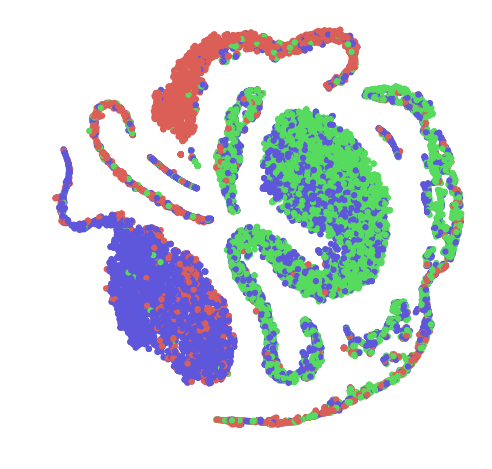

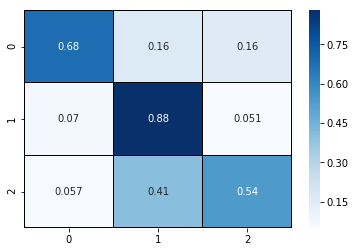

KNN_auc:0.705000


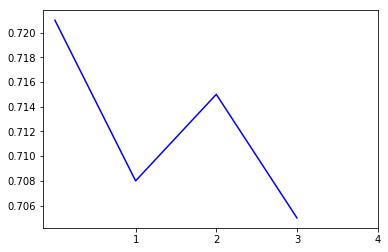

 19%|█▉        | 4/21 [50:24<3:34:13, 756.09s/it]

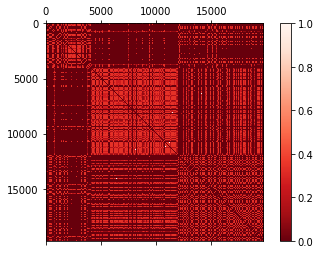

Epoch 1/3
19717/19717 [==============================] - 6s 289us/step - loss: 1.1346
Epoch 2/3
19717/19717 [==============================] - 1s 26us/step - loss: 1.3320
Epoch 3/3
19717/19717 [==============================] - 1s 26us/step - loss: 1.6050


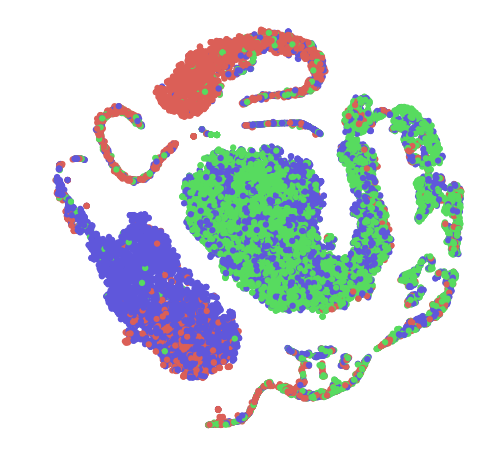

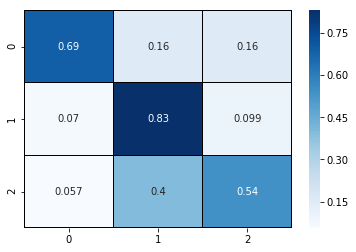

KNN_auc:0.688000


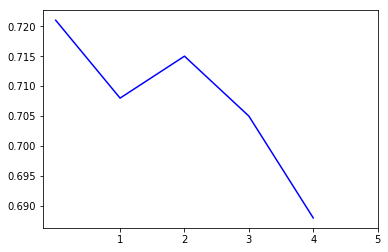

 24%|██▍       | 5/21 [1:03:18<3:22:36, 759.75s/it]

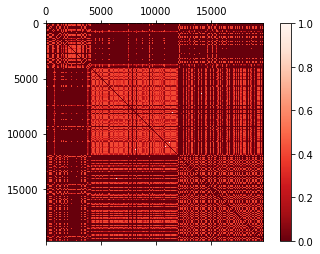

Epoch 1/3
19717/19717 [==============================] - 6s 282us/step - loss: 1.2441
Epoch 2/3
19717/19717 [==============================] - 0s 25us/step - loss: 1.1645
Epoch 3/3
19717/19717 [==============================] - 0s 24us/step - loss: 1.2210


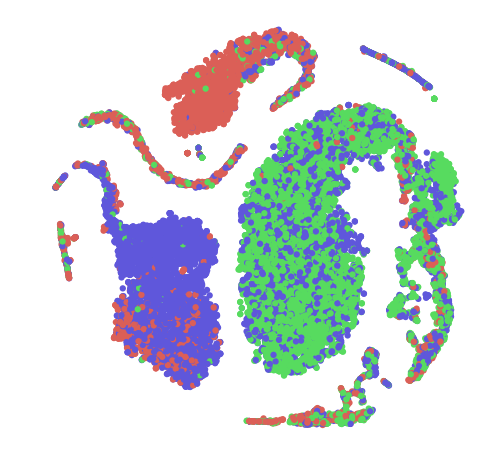

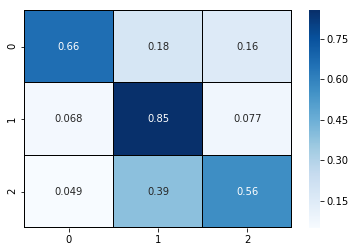

KNN_auc:0.701000


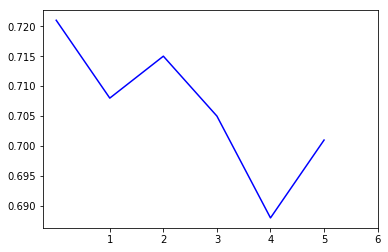

 29%|██▊       | 6/21 [1:16:30<3:11:15, 765.01s/it]

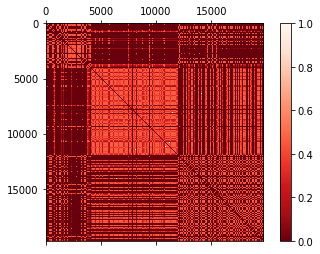

Epoch 1/3
19717/19717 [==============================] - 6s 288us/step - loss: 1.4469
Epoch 2/3
19717/19717 [==============================] - 1s 26us/step - loss: 1.9277
Epoch 3/3
19717/19717 [==============================] - 0s 24us/step - loss: 1.7517


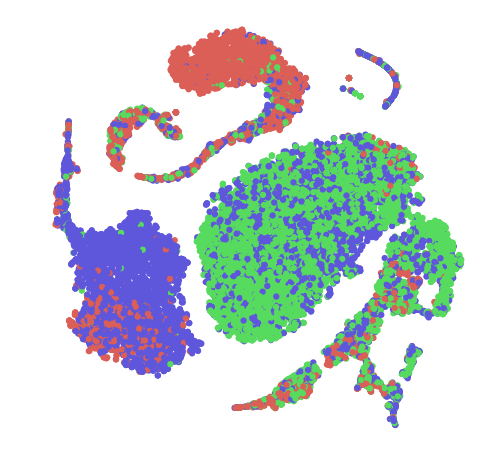

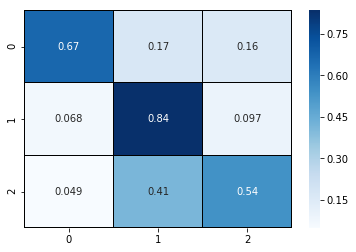

KNN_auc:0.684000


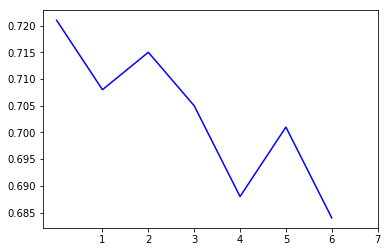

 33%|███▎      | 7/21 [1:30:03<3:00:07, 771.95s/it]

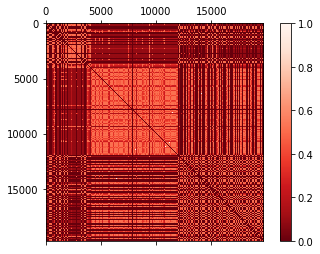

Epoch 1/3
19717/19717 [==============================] - 6s 288us/step - loss: 2.3449
Epoch 2/3
19717/19717 [==============================] - 1s 26us/step - loss: 2.2473
Epoch 3/3
19717/19717 [==============================] - 1s 25us/step - loss: 2.0826


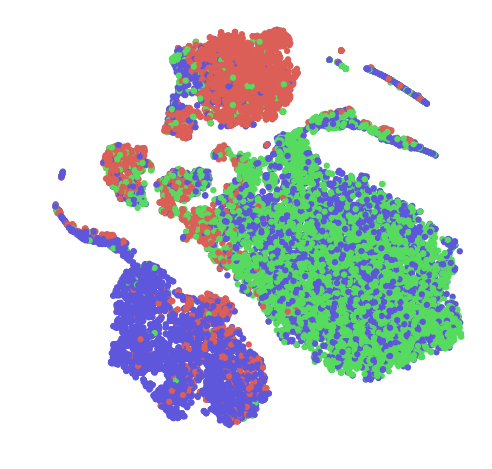

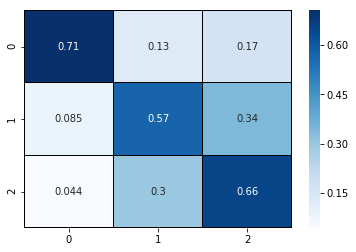

KNN_auc:0.630000


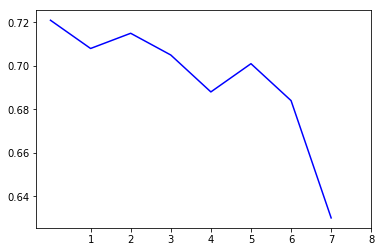

 38%|███▊      | 8/21 [1:43:57<2:48:56, 779.70s/it]

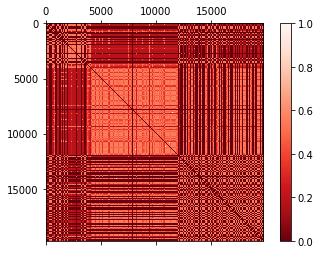

Epoch 1/3
19717/19717 [==============================] - 6s 282us/step - loss: 2.1185
Epoch 2/3
19717/19717 [==============================] - 0s 25us/step - loss: 2.5208
Epoch 3/3
19717/19717 [==============================] - 0s 24us/step - loss: 2.2358


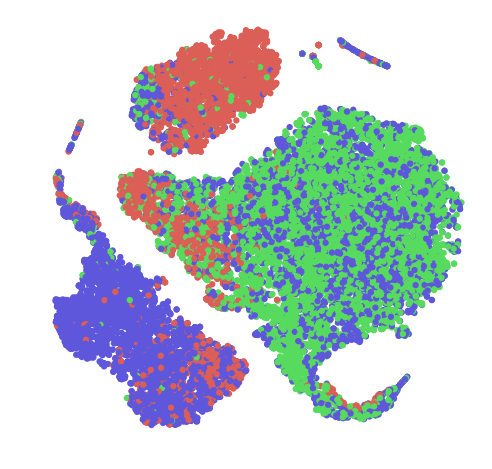

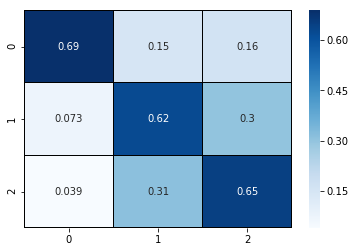

KNN_auc:0.646000


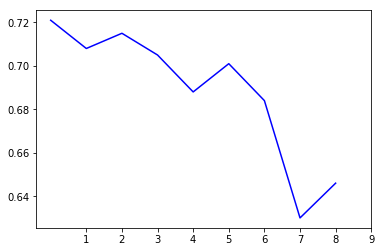

 43%|████▎     | 9/21 [1:57:55<2:37:14, 786.22s/it]

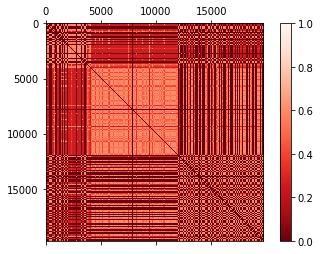

Epoch 1/3
19717/19717 [==============================] - 6s 281us/step - loss: 2.2251
Epoch 2/3
19717/19717 [==============================] - 0s 24us/step - loss: 2.1244
Epoch 3/3
19717/19717 [==============================] - 0s 25us/step - loss: 2.0446


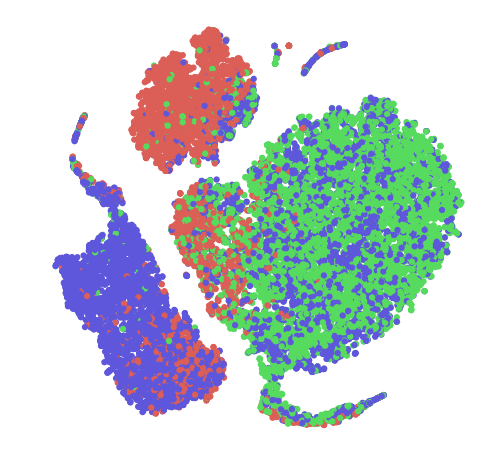

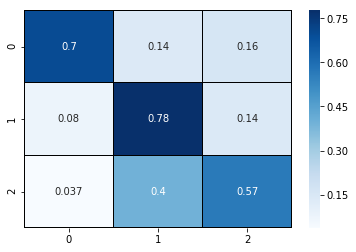

KNN_auc:0.678000


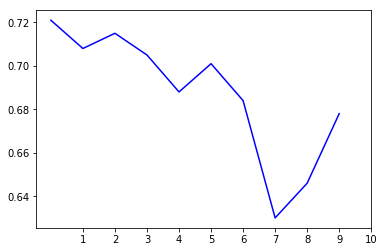

 48%|████▊     | 10/21 [2:11:38<2:24:48, 789.83s/it]

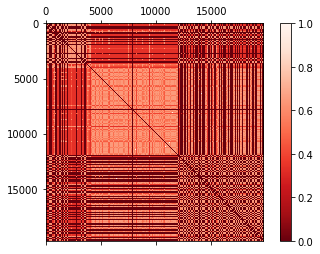

Epoch 1/3
19717/19717 [==============================] - 6s 290us/step - loss: 1.6769
Epoch 2/3
19717/19717 [==============================] - 0s 25us/step - loss: 2.8548
Epoch 3/3
19717/19717 [==============================] - 0s 25us/step - loss: 2.7472


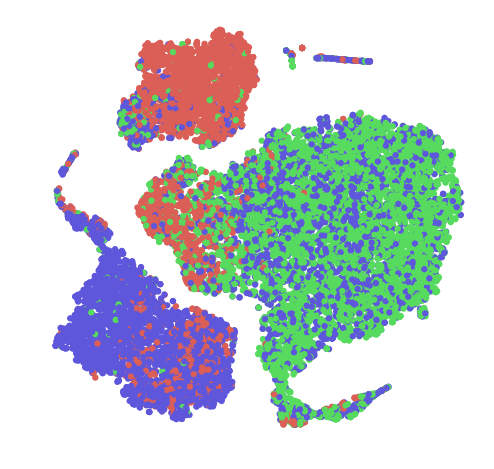

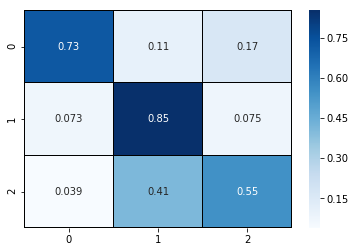

KNN_auc:0.707000


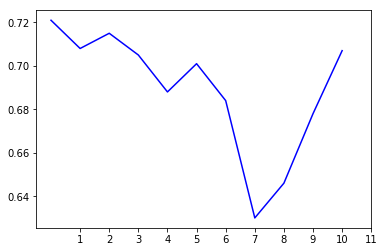

 52%|█████▏    | 11/21 [2:25:17<2:12:04, 792.47s/it]

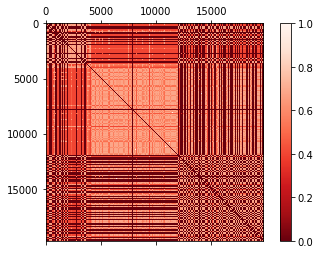

Epoch 1/3
19717/19717 [==============================] - 6s 281us/step - loss: 2.4630
Epoch 2/3
19717/19717 [==============================] - 0s 25us/step - loss: 3.0386
Epoch 3/3
19717/19717 [==============================] - 1s 25us/step - loss: 2.7060


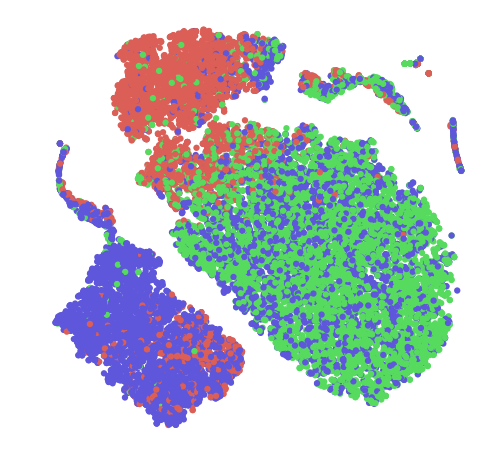

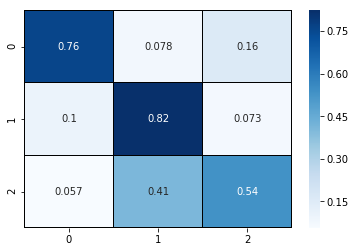

KNN_auc:0.695000


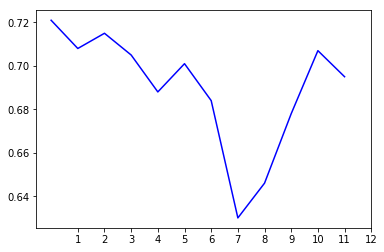

 57%|█████▋    | 12/21 [2:39:08<1:59:21, 795.73s/it]

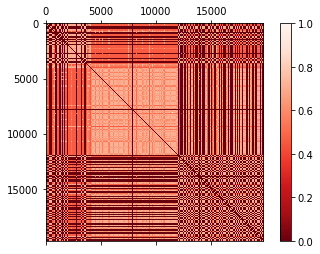

Epoch 1/3
19717/19717 [==============================] - 6s 282us/step - loss: 2.4405
Epoch 2/3
19717/19717 [==============================] - 1s 26us/step - loss: 2.4659
Epoch 3/3
19717/19717 [==============================] - 0s 24us/step - loss: 2.8023


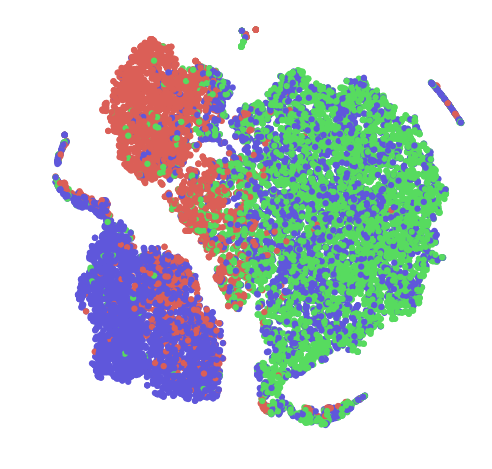

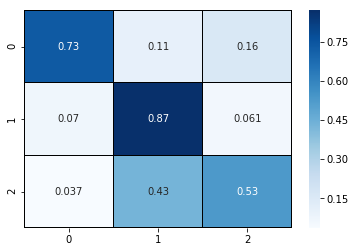

KNN_auc:0.707000


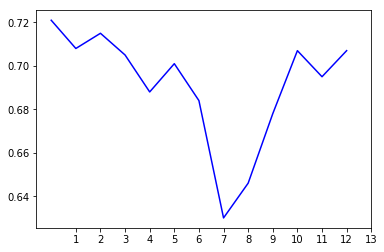

 62%|██████▏   | 13/21 [2:52:37<1:46:14, 796.76s/it]

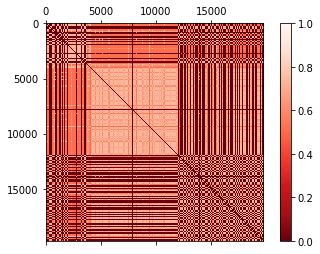

Epoch 1/3
19717/19717 [==============================] - 6s 296us/step - loss: 2.4865
Epoch 2/3
19717/19717 [==============================] - 0s 24us/step - loss: 2.4698
Epoch 3/3
19717/19717 [==============================] - 0s 24us/step - loss: 2.4783


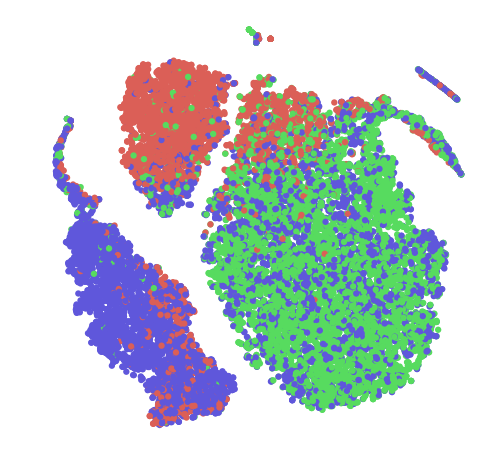

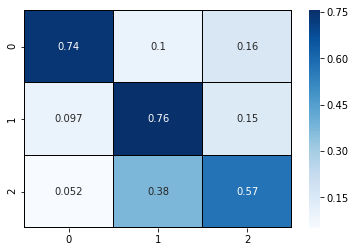

KNN_auc:0.678000


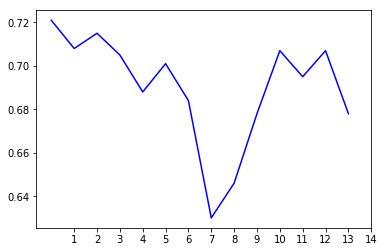

 67%|██████▋   | 14/21 [3:06:32<1:33:16, 799.44s/it]

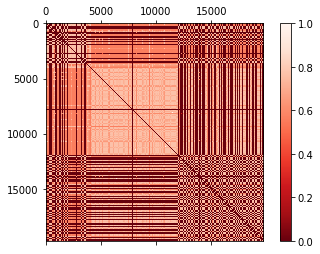

Epoch 1/3
19717/19717 [==============================] - 6s 280us/step - loss: 2.3933
Epoch 2/3
19717/19717 [==============================] - 0s 24us/step - loss: 2.5417
Epoch 3/3
19717/19717 [==============================] - 0s 25us/step - loss: 2.6164


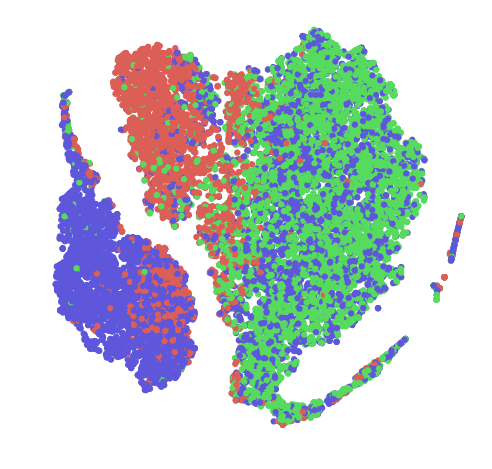

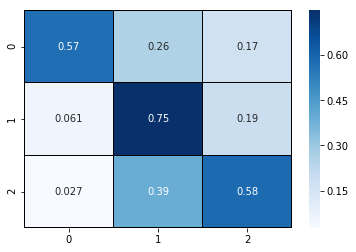

KNN_auc:0.649000


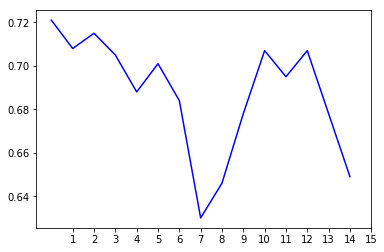

 71%|███████▏  | 15/21 [3:20:18<1:20:07, 801.22s/it]

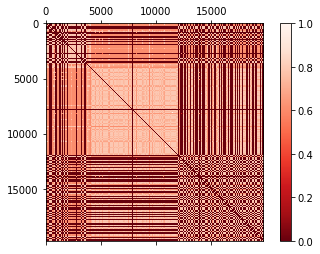

Epoch 1/3
19717/19717 [==============================] - 6s 286us/step - loss: 2.7770
Epoch 2/3
19717/19717 [==============================] - 0s 25us/step - loss: 2.7134
Epoch 3/3
19717/19717 [==============================] - 1s 26us/step - loss: 2.8013


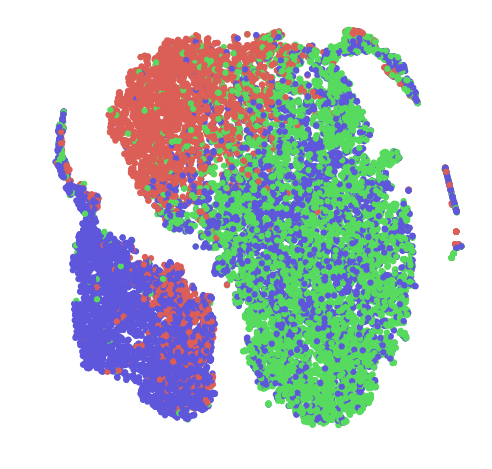

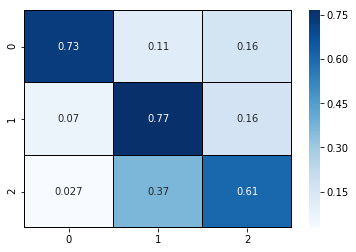

KNN_auc:0.694000


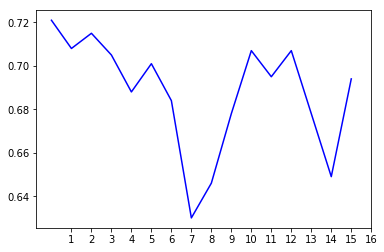

 76%|███████▌  | 16/21 [3:34:34<1:07:03, 804.67s/it]

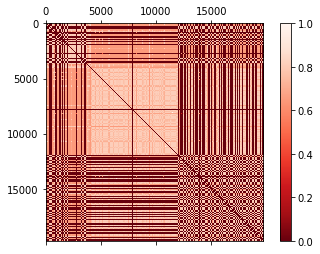

Epoch 1/3
19717/19717 [==============================] - 6s 283us/step - loss: 2.7785
Epoch 2/3
19717/19717 [==============================] - 0s 24us/step - loss: 3.0435
Epoch 3/3
19717/19717 [==============================] - 0s 24us/step - loss: 2.9063


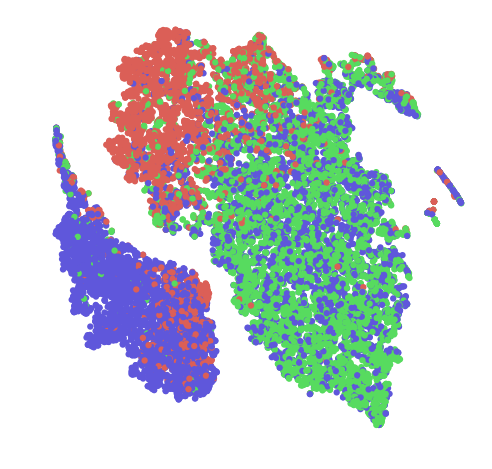

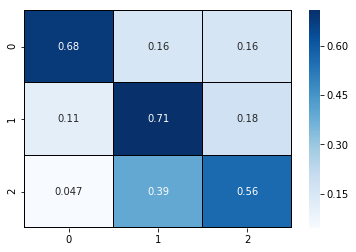

KNN_auc:0.643000


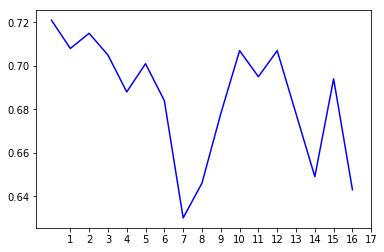

 81%|████████  | 17/21 [3:47:59<53:38, 804.66s/it]  

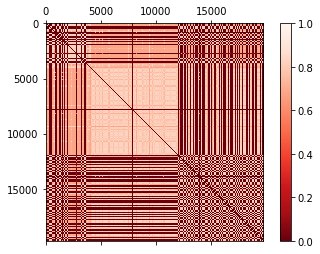

Epoch 1/3
19717/19717 [==============================] - 6s 287us/step - loss: 2.8629
Epoch 2/3
19717/19717 [==============================] - 0s 25us/step - loss: 3.0667
Epoch 3/3
19717/19717 [==============================] - 0s 25us/step - loss: 3.1879


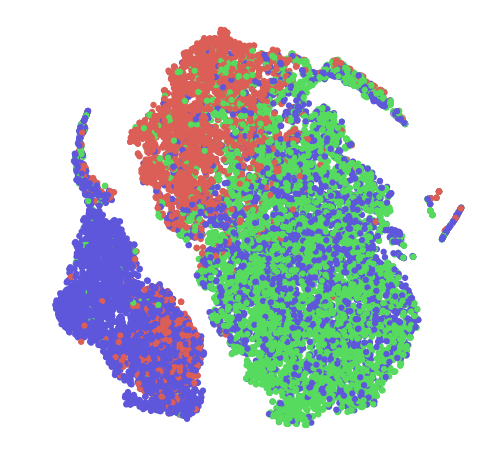

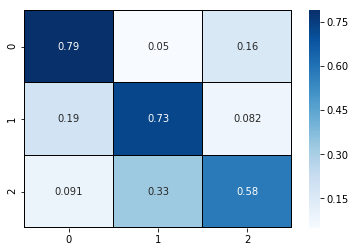

KNN_auc:0.678000


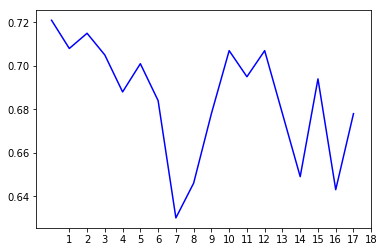

 86%|████████▌ | 18/21 [4:01:47<40:17, 805.98s/it]

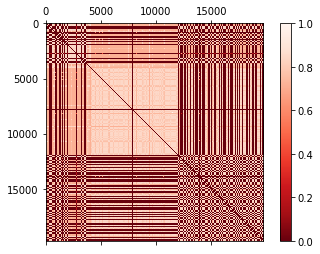

Epoch 1/3
19717/19717 [==============================] - 6s 282us/step - loss: 3.1309
Epoch 2/3
19717/19717 [==============================] - 0s 25us/step - loss: 3.1779
Epoch 3/3
19717/19717 [==============================] - 0s 25us/step - loss: 3.1382


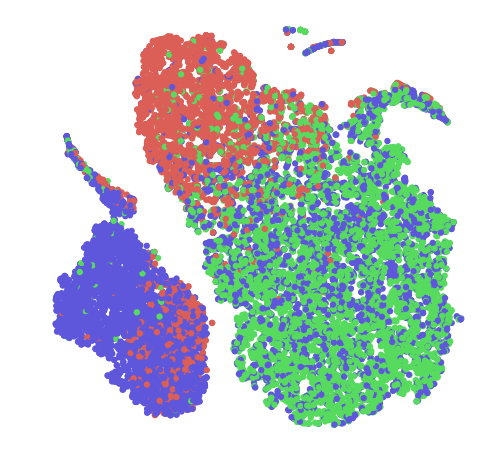

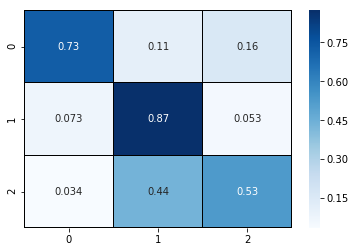

KNN_auc:0.707000


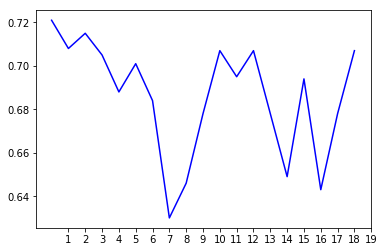

 90%|█████████ | 19/21 [4:15:15<26:52, 806.10s/it]

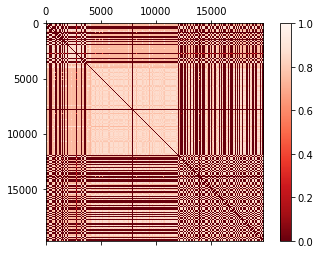

Epoch 1/3
19717/19717 [==============================] - 6s 286us/step - loss: 3.1359
Epoch 2/3
19717/19717 [==============================] - 0s 24us/step - loss: 3.3793
Epoch 3/3
19717/19717 [==============================] - 1s 25us/step - loss: 3.1853


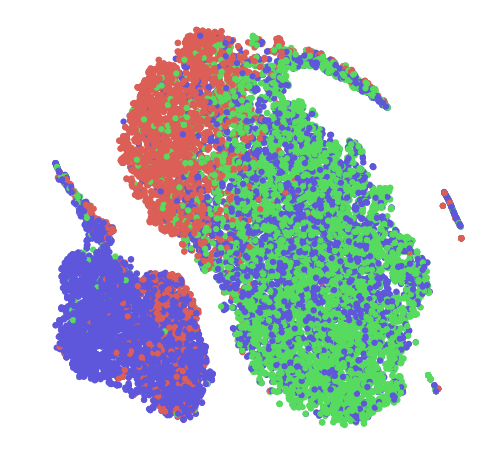

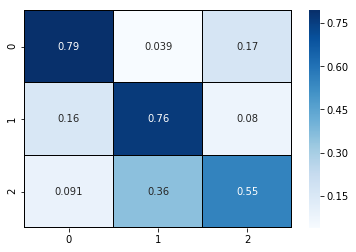

KNN_auc:0.683000


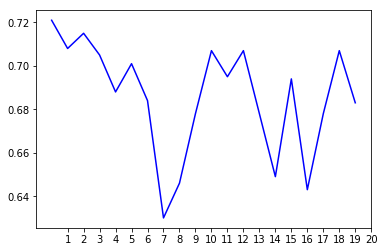

 95%|█████████▌| 20/21 [4:29:08<13:27, 807.45s/it]

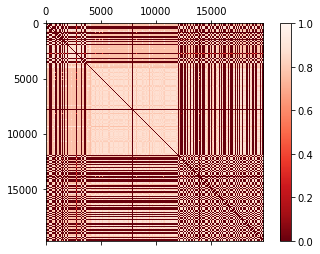

Epoch 1/3
19717/19717 [==============================] - 6s 290us/step - loss: 3.3002
Epoch 2/3
19717/19717 [==============================] - 1s 25us/step - loss: 3.5202
Epoch 3/3
19717/19717 [==============================] - 0s 24us/step - loss: 3.5206


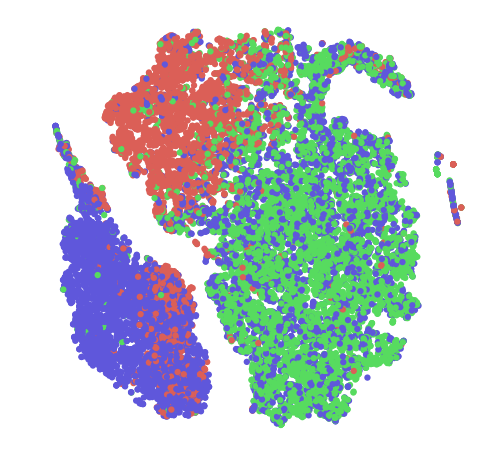

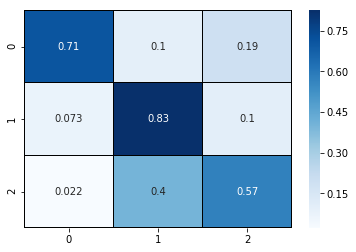

KNN_auc:0.703000


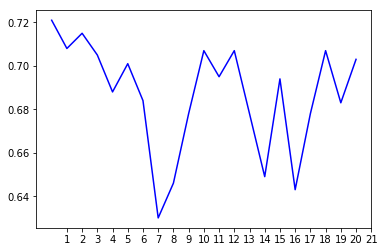

100%|██████████| 21/21 [4:42:57<00:00, 808.46s/it]

最高准确率：0.721000
平均准确率：0.686667


In [3]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.patheffects as PathEffects
import seaborn as sn
K.clear_session()
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
#     print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)

KTF.set_session(sess)

dataset = 'pubmed'  #citeseer   cora  pubmed

feature = load_data(dataset)[1].toarray()
ACC=[0,0,0,0,0]
for i in range(1):
#####逼近式
    alpha = 0.95  ###局部强度
#     t = 1.0/8 
    adj = load_data(dataset)[0].toarray()
#     distance = np.zeros([feature.shape[0],feature.shape[0]])
#     for i in range(feature.shape[0]):
#         distance[i] = np.sqrt(np.sum(np.square(feature - feature[i]) ,axis=1)) ###计算欧氏距离
            
#     Top_10 = np.sort(distance,axis=1)[:,1:51]
        
#     sigma = np.std(Top_10,axis=1)
#     ######高斯核
#     adj = np.zeros([feature.shape[0],feature.shape[0]])
#     for i in range(feature.shape[0]):
#         adj[i] = np.exp(-np.mean( np.transpose(np.transpose(np.square(feature - feature[i]))/sigma)/sigma[i]/t ,axis=1       ))
    
    ######线性核
#     adj = np.zeros([feature.shape[0],feature.shape[0]])
#     for i in range(feature.shape[0]):
#         adj[i] = np.dot(feature/np.sqrt(np.sum(np.square(feature),axis=1,keepdims=True)),feature[i]/np.sqrt(np.sum(np.square(feature[i]))))
#     adj = adj - np.eye(adj.shape[1])
    
    adj = adj.astype('float32')
    adj_normalize = normalize_adj(adj)
    adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - alpha*adj_normalize.toarray())
    # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)
    adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')

    ######penalty of degree
#     adj_tf = tf.convert_to_tensor(adj, dtype='float32')
#     # C = adj_normalize_tf
#     C = adj_tf
#     # C = adj_tf + K.dot(adj_tf, adj_tf) - K.dot(adj_tf, adj_tf)*K.eye(feature.shape[0])
#     D = K.dot(adj_tf, adj_tf)*K.eye(feature.shape[0])  ##degree matrix
#     D_pow = K.pow(D + 1e-10, -1)*K.eye(feature.shape[0])

#     D_norm = K.pow(D + 1e-20, -0.5)*K.eye(feature.shape[0]) ####D^-0.5
#     W = K.dot(K.dot(D_pow, C), D_pow)
#     W = K.dot(K.dot(D_norm, W), D_norm)
#     L = K.eye(feature.shape[0]) - W
#     L_array = K.eval(L)

    encoding_dim_1 = 1024
    encoding_dim_2 = 256
    t = 1.0/8  ##高斯核系数
    rate = 0.1  ###相似度矩阵学习率
    iter_n = []
    acc = []
    if dataset == 'citeseer':
        onehot = load_data(dataset)[8]
        isolated = np.where(np.sum(onehot,axis=-1)==0)
        for i in isolated[0]:
            onehot[i] = np.copy(onehot[adj.tolist()[i].index(1)])
    else:
        onehot = load_data(dataset)[8]
    y = onehot2index(onehot)
    Mat_block = np.zeros_like(adj)
    y = onehot2index(onehot)
    for i in range(onehot.shape[1]):
        for j in np.where(y==i)[0]:
            Mat_block[np.where(y==i)[0],j] = 1
    Mat_block = Mat_block - np.eye(adj.shape[0])
    Mat_block_array = Mat_block
#     Mat_block = tf.convert_to_tensor(Mat_block, dtype='float32')


#     for n in tqdm(range(20)):
#         D_vect = np.sqrt(np.sum(adj,axis=0))
    order_0 = Input(shape=(feature.shape[1],)) 

    def graph_convex(x):
        x1 = K.dot(adj_normalize_tf,x)
        return x1

    ###########不对称
    order_1 = Lambda(function=graph_convex)(order_0)
#     order_1 = BatchNormalization(axis = -1)(order_1)
    encoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_1)  
#     encoded_1 = Dropout(0.5)(encoded_1)
    encoded_1 = BatchNormalization(axis = -1)(encoded_1)

    order_2 = Lambda(function= graph_convex)(encoded_1)
#     order_2 = BatchNormalization(axis = -1)(order_2)
    encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(order_2)
#     Res = Dense(encoding_dim_2, activation='relu', use_bias=True)(order_0)   
#     encoded_2 = keras.layers.Add()([encoded_2,Res])
#     encoded_2 = Dropout(0.5)(encoded_2)
    encoded_22 = BatchNormalization(axis = -1)(encoded_2)

    order_3 = Lambda(function= graph_convex)(encoded_22)
#     order_3 = BatchNormalization(axis = -1)(order_3)
    decoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_3)  
#     decoded_1 = Dropout(0.5)(decoded_1)
    decoded_1 = BatchNormalization(axis = -1)(decoded_1)

    order_4 = Lambda(function= graph_convex)(decoded_1)
#     order_4 = BatchNormalization(axis = -1)(order_4)
    decoded_2 = Dense(feature.shape[1], activation='sigmoid', use_bias=True)(order_4)  
#     decoded_2 = BatchNormalization(axis = -1)(decoded_2)

    def myloss(y_true, y_pred, e= 1e-5):
        recon = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
#         trace = K.sum(K.dot(K.dot(K.transpose(encoded_2), L), encoded_2) * K.eye(encoding_dim_2))/encoding_dim_2
#         block = K.sqrt(K.mean(K.square(Mat_block - K.dot(encoded_2,K.transpose(encoded_2)))))
#         block = K.sum(K.binary_crossentropy(Mat_block, K.dot(K.l2_normalize(encoded_2,axis=-1),K.transpose(K.l2_normalize(encoded_2,axis=-1)))))
#         orth = K.mean(K.square(K.dot(K.dot(K.transpose(encoded_2), D), encoded_2) - K.eye(encoding_dim_2)))
        return recon 

    autoencoder = Model(inputs=order_0, outputs=decoded_2)  
#     encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
    encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
#     decoder_1 = Model(inputs=order_0, outputs=decoded_1)
    test = Model(inputs=order_0, outputs=order_1)
    EP = 50
#     D_vect = np.sqrt(np.sum(adj,axis=0))
    for n in tqdm(range(21)):

        #块效应邻接矩阵
       
        adj_reindex = np.eye(adj.shape[0])
        count = 0
        for i in range(onehot.shape[1]):
            adj_reindex[count:count+np.where(y==i)[0].shape[0]] = np.copy(adj[np.where(y==i)])
            count = count + np.where(y==i)[0].shape[0]
        alt = np.copy(np.transpose(adj_reindex))
        count = 0
        for i in range(onehot.shape[1]):
            adj_reindex[count:count+np.where(y==i)[0].shape[0]] = np.copy(alt[np.where(y==i)])
            count = count + np.where(y==i)[0].shape[0]

        fig = plt.figure() #调用figure创建一个绘图对象
        ax = fig.add_subplot(111)
        cax = ax.matshow(adj_reindex, vmin=0, vmax=1, cmap='Reds_r')  #绘制热力图，从-1到1
        fig.colorbar(cax)  #将matshow生成热力图设置为颜色渐变条
        ticks = np.arange(0,9,1) #生成0-9，步长为1
        if n%5 == 0:
            plt.savefig('/home/lifuzhen/gcn/%s_unrefined_%d.eps'%(dataset,n))
        plt.show()
        #块效应邻接矩阵 end
#         D_vect = np.power(np.sum(adj,axis=0),1/10)
        
        adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        autoencoder.compile(optimizer=adam, loss=myloss)
        autoencoder.fit(feature, feature, epochs=EP,batch_size=feature.shape[0],shuffle=False,verbose=1)

        encoded_node_1 = encoder_2.predict(feature,batch_size=feature.shape[0])

        proj3 = TSNE(random_state=123,perplexity=30,early_exaggeration=12,init='random').fit_transform(encoded_node_1)

        y = onehot2index(onehot)
    #     plt.subplot(133)
        fig = plt.figure()
        scatter(proj3, y)
    #     plt.savefig('/home/lifuzhen/gcn/visulization.png')
        plt.show()

        trainX , trainY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
        testX, testY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

        knn = KNeighborsClassifier()
        knn.fit(trainX,trainY)
        pred_KNN = knn.predict(testX)
        auc_KNN = metrics.accuracy_score(testY , pred_KNN)

        confusion = metrics.confusion_matrix(testY , pred_KNN)
        confusion_matrix = confusion/np.sum(confusion,axis=-1,keepdims=1)
        np.round(confusion_matrix,3)
        sn.heatmap(confusion_matrix,annot=True,cmap='Blues',linecolor='black',linewidths=0.1)
        if n%5 == 0:
            plt.savefig('/home/lifuzhen/gcn/%s_confusion_matrix_%d.eps'%(dataset,n))
        plt.show()
        print('KNN_auc:%f'%auc_KNN)
        iter_n.append(n)
        acc.append(auc_KNN)
        plt.plot(iter_n, acc, 'b')
        plt.xticks(range(1,len(acc)+1))
        plt.show()
        autoencoder.save_weights('GDN.h5')
        K.clear_session()
        ######计算方差#########
#         distance = np.zeros([feature.shape[0],feature.shape[0]])
#         for i in range(feature.shape[0]):
#             distance[i] = np.sqrt(np.sum(np.square(encoded_node_1 - encoded_node_1[i]) ,axis=1)) ###计算欧氏距离
            
#         Top_10 = np.sort(distance,axis=1)[:,1:11]
        
#         sigma = np.std(Top_10,axis=1)
#         #####计算方差end####################

# #         ###高斯核邻接矩阵embedding 度方案@#########
# #         adj_learn = np.zeros([feature.shape[0],feature.shape[0]])
# #         for i in range(feature.shape[0]):
# #             adj_learn[i] = np.exp(-np.mean(     np.transpose(np.transpose(np.square(encoded_node_1 - encoded_node_1[i]))*D_vect)*D_vect[i]/t ,axis=1       ))
       
#         #######高斯核邻接矩阵embedding 方差估计方案#######
#         adj_learn = np.zeros([feature.shape[0],feature.shape[0]])
#         for i in range(feature.shape[0]):
#             adj_learn[i] = np.exp(-np.mean( np.transpose(np.transpose(np.square(encoded_node_1 - encoded_node_1[i]))/sigma)/sigma[i]/t ,axis=1))
        adj_learn = np.zeros([feature.shape[0],feature.shape[0]])
        for i in range(feature.shape[0]):
            adj_learn[i] = np.copy(np.dot(encoded_node_1/np.sqrt(np.sum(np.square(encoded_node_1),axis=1,keepdims=True)),encoded_node_1[i]/np.sqrt(np.sum(np.square(encoded_node_1[i])))))
        
        adj_learn[adj_learn<0 ] = 0
        adj_learn = adj_learn - np.eye(adj_learn.shape[1])
        adj_delta = adj_learn - adj

#         margin = 0.5
#     #     delta = 0.01
#         index_alter_P = np.where((0 < adj_delta)&(adj_delta < margin))
#         index_alter_N = np.where((-margin < adj_delta)& (adj_delta< 0))
#         adj[index_alter_P] += adj_delta[index_alter_P]/2.0
#         adj[index_alter_N] += adj_delta[index_alter_N]/2.0
#         adj[index_alter_P] += 0.05
#         adj[index_alter_N] -= 0.05

#         adj = model_metric.predict(encoded_node_1,batch_size=encoded_node_1.shape[0])
        adj = (1-rate)*adj + rate*(adj_learn-np.eye(adj_learn.shape[1]))
        adj[adj<0.09] = 0
        adj_normalize_0 = normalize_adj(adj)
        adj_normalize = normalize_adj(adj) ######rate or (1-rate)&rate
        adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - alpha*adj_normalize.toarray())
        adj_normalize_tf = tf.convert_to_tensor(adj_normalize, dtype='float32')
        
        
        order_0 = Input(shape=(feature.shape[1],)) 

        def graph_convex(x):
            x1 = K.dot(adj_normalize_tf,x)
            return x1

        ###########不对称
        order_1 = Lambda(function=graph_convex)(order_0)
#         order_1 = BatchNormalization(axis = -1)(order_1)
        encoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_1)  
    #     encoded_1 = Dropout(0.5)(encoded_1)
        encoded_1 = BatchNormalization(axis = -1)(encoded_1)

        order_2 = Lambda(function= graph_convex)(encoded_1)
#         order_2 = BatchNormalization(axis = -1)(order_2)
        encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(order_2)
#         Res = Dense(encoding_dim_2, activation='relu', use_bias=True)(order_0)   
#         encoded_2 = keras.layers.Add()([encoded_2,Res])
    #     encoded_2 = Dropout(0.5)(encoded_2)
        encoded_22 = BatchNormalization(axis = -1)(encoded_2)

        order_3 = Lambda(function= graph_convex)(encoded_22)
#         order_3 = BatchNormalization(axis = -1)(order_3)
        decoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_3)  
    #     decoded_1 = Dropout(0.5)(decoded_1)
        decoded_1 = BatchNormalization(axis = -1)(decoded_1)

        order_4 = Lambda(function= graph_convex)(decoded_1)
#         order_4 = BatchNormalization(axis = -1)(order_4)
        decoded_2 = Dense(feature.shape[1], activation='sigmoid', use_bias=True)(order_4)  
    #     decoded_2 = BatchNormalization(axis = -1)(decoded_2)
#         Mat_block = tf.convert_to_tensor(Mat_block_array, dtype='float32')
        def myloss(y_true, y_pred, e= 1e-5):
            recon = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
#             trace = K.sum(K.dot(K.dot(K.transpose(encoded_2), K.variable(L_array)), encoded_2) * K.eye(encoding_dim_2))/encoding_dim_2
#             block = K.sqrt(K.mean(K.square(Mat_block - K.dot(encoded_2,K.transpose(encoded_2)))))
#             block = K.sum(K.binary_crossentropy(Mat_block, K.dot(K.l2_normalize(encoded_2,axis=-1),K.transpose(K.l2_normalize(encoded_2,axis=-1)))))
#         orth = K.mean(K.square(K.dot(K.dot(K.transpose(encoded_2), D), encoded_2) - K.eyle(encoding_dim_2)))
            return recon 

        autoencoder = Model(inputs=order_0, outputs=decoded_2)  
    #     encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
        encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
    #     decoder_1 = Model(inputs=order_0, outputs=decoded_1)
        test = Model(inputs=order_0, outputs=order_1)
        autoencoder.load_weights('GDN.h5')
        EP = 3
#         print(test.predict(feature, batch_size=feature.shape[0]))
    print('最高准确率：%f'%max(acc))
    print('平均准确率：%f'%(sum(acc)/len(acc)))
    ACC += acc

In [63]:
confusion = metrics.confusion_matrix(testY , pred_KNN)
confusion_matrix = confusion/np.sum(confusion,axis=-1,keepdims=1)
np.round(confusion_matrix,3)

array([[0.338, 0.416, 0.078, 0.013, 0.091, 0.065],
       [0.104, 0.681, 0.11 , 0.   , 0.044, 0.06 ],
       [0.017, 0.149, 0.702, 0.066, 0.017, 0.05 ],
       [0.078, 0.065, 0.078, 0.719, 0.022, 0.039],
       [0.047, 0.071, 0.012, 0.012, 0.822, 0.036],
       [0.012, 0.062, 0.05 , 0.025, 0.05 , 0.8  ]])

In [18]:
np.where(load_data(dataset)[0].toarray()[3212]==1)

(array([1392, 2857]),)

In [26]:
for i in isolated[0]:
    print(i)

2407
2489
2553
2682
2781
2953
3042
3063
3212
3214
3250
3292
3305
3306
3309


In [24]:
isolated

(array([2407, 2489, 2553, 2682, 2781, 2953, 3042, 3063, 3212, 3214, 3250,
        3292, 3305, 3306, 3309]),)

In [31]:
np.linalg.matrix_rank(adj_normalize_0.toarray())

/home/lifuzhen/virtual_pytorch_py3.5/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/lifuzhen/virtual_pytorch_py3.5/lib/python3.5/site-packages/numpy/linalg/linalg.py:1647: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


0

In [4]:
acc

[0.721,
 0.708,
 0.715,
 0.705,
 0.688,
 0.701,
 0.684,
 0.63,
 0.646,
 0.678,
 0.707,
 0.695,
 0.707,
 0.678,
 0.649,
 0.694,
 0.643,
 0.678,
 0.707,
 0.683,
 0.703]

In [22]:
dataset = 'citeseer'
if dataset == 'citeseer':
    onehot = load_data(dataset)[8]
    isolated = np.where(np.sum(onehot,axis=-1)==0)
    for i in isolated[0]:
        onehot[i] = np.copy(onehot[load_data(dataset)[0].toarray().tolist()[i].index(1)])
else:
    onehot = load_data(dataset)[8]
y = onehot2index(onehot)

In [24]:
feature = load_data('citeseer')[1].toarray()

# distance = np.zeros([feature.shape[0],feature.shape[0]])
# for i in range(feature.shape[0]):
#     distance[i] = np.sqrt(np.sum(np.square(feature - feature[i]) ,axis=1)) ###计算欧氏距离

# Top_10 = np.sort(distance,axis=1)[:,1:51]

# sigma = np.std(Top_10,axis=1)
# ######高斯核
# adj = np.zeros([feature.shape[0],feature.shape[0]])
# for i in range(feature.shape[0]):
#     adj[i] = np.exp(-np.mean( np.transpose(np.transpose(np.square(feature - feature[i]))/sigma)/sigma[i]/t ,axis=1       ))

#####线性核
adj = np.zeros([feature.shape[0],feature.shape[0]])
for i in range(feature.shape[0]):
    adj[i] = np.dot(feature/(np.sqrt(np.sum(np.square(feature),axis=1,keepdims=True))+1e-10),feature[i]/(1e-10+np.sqrt(np.sum(np.square(feature[i])))))
adj = adj - np.eye(adj.shape[1])
adj[adj<0] = 0

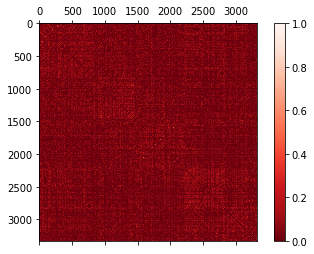

In [25]:
adj_reindex = np.eye(adj.shape[0])
QQQQ = np.eye(adj.shape[0])
n = 0
for i in range(6):
    adj_reindex[n:n+np.where(y==i)[0].shape[0]] = adj[np.where(y==i)]
    n = n + np.where(y==i)[0].shape[0]
alt = np.copy(np.transpose(adj_reindex))
n = 0
for i in range(6):
    adj_reindex[n:n+np.where(y==i)[0].shape[0]] = alt[np.where(y==i)]
    n = n + np.where(y==i)[0].shape[0]

fig = plt.figure() #调用figure创建一个绘图对象
ax = fig.add_subplot(111)
cax = ax.matshow(adj_reindex, vmin=0, vmax=1, cmap='Reds_r')  #绘制热力图，从-1到1
fig.colorbar(cax)  #将matshow生成热力图设置为颜色渐变条
ticks = np.arange(0,9,1) #生成0-9，步长为1
plt.savefig('/home/lifuzhen/gcn/citeseer_unrefined_original.eps')
plt.show()

In [20]:
np.where(np.sum(onehot,axis=-1)==0)[0]

array([2407, 2489, 2553, 2682, 2781, 2953, 3042, 3063, 3212, 3214, 3250,
       3292, 3305, 3306, 3309])

In [118]:
id(adj_reindex)

140029762608304

In [119]:
id(QQQQ)

140029762497392

In [120]:
id(adj)

140029868996368

AttributeError: Unknown property annot

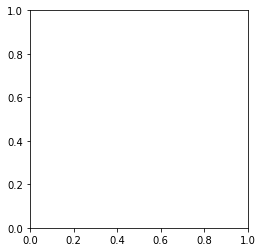

In [65]:
import numpy
# correlations = data.corr()  #计算变量之间的相关系数矩阵
# plot correlation matrix
fig = plt.figure() #调用figure创建一个绘图对象
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, vmin=0, vmax=1, cmap='Reds_r')  #绘制热力图，从-1到1
fig.colorbar(cax)  #将matshow生成热力图设置为颜色渐变条
ticks = numpy.arange(0,9,1) #生成0-9，步长为1
plt.savefig('/home/lifuzhen/gcn/refined.eps')
plt.show()

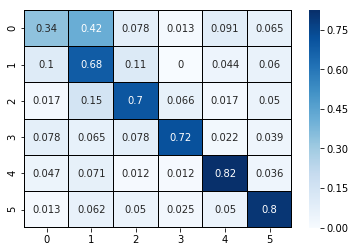

In [78]:
import seaborn as sn
sn.heatmap(confusion_matrix,annot=True,cmap='Blues',linecolor='black',linewidths=0.1)
plt.savefig('/home/lifuzhen/gcn/confusion_matrix.png')

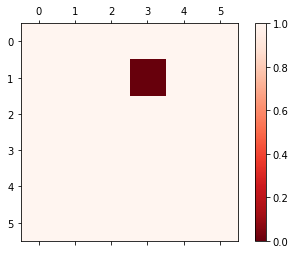

In [57]:
import numpy
# correlations = data.corr()  #计算变量之间的相关系数矩阵
# plot correlation matrix
fig = plt.figure() #调用figure创建一个绘图对象
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, vmin=0, vmax=1, cmap='Reds_r')  #绘制热力图，从-1到1
fig.colorbar(cax)  #将matshow生成热力图设置为颜色渐变条
ticks = numpy.arange(0,9,1) #生成0-9，步长为1
plt.savefig('/home/lifuzhen/gcn/refined.eps')
plt.show()

In [66]:
test.predict(feature, batch_size=feature.shape[0])

array([[1.4852979e+00, 1.0061127e-03, 2.5952994e-03, ..., 0.0000000e+00,
        2.3272184e-03, 2.6225359e-03],
       [1.0061127e-03, 1.7679818e+00, 4.9495667e-01, ..., 0.0000000e+00,
        1.2023158e-03, 1.0032346e-03],
       [2.5952994e-03, 4.9495667e-01, 1.4140695e+00, ..., 0.0000000e+00,
        3.3116657e-03, 2.7156386e-03],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.6036041e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.3272184e-03, 1.2023158e-03, 3.3116657e-03, ..., 0.0000000e+00,
        1.5521039e+00, 5.9703320e-01],
       [2.6225359e-03, 1.0032346e-03, 2.7156386e-03, ..., 0.0000000e+00,
        5.9703320e-01, 1.3826927e+00]], dtype=float32)

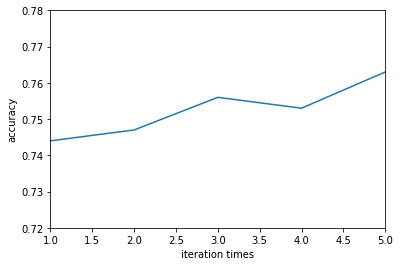

In [38]:
acc = [0.744,0.747,0.756,0.753,0.763]
plt.plot(range(1,6),acc)
plt.xlim(1,5)
plt.ylim(0.72,0.78)
plt.xlabel('iteration times')
plt.ylabel('accuracy')
plt.savefig('/home/lifuzhen/gcn/refeff.eps')

In [42]:
import networkx as nx
adj = load_data('pubmed')[0].toarray()
G=nx.Graph()
for i in range(adj.shape[0]):
    for j in range(adj.shape[1]):
    #     G.add_nodes_from(adj)
        if adj[i][j] == 1:
            G.add_edge(i,j)

In [43]:
labels = load_data('pubmed')[8]

In [44]:
import numpy as np
labels = np.argmax(labels,axis=1)

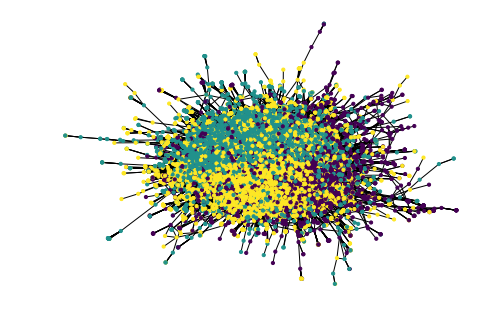

In [45]:
nx.draw(G,node_color=labels,with_labels=False,node_size=10)

In [49]:
import networkx as nx
import scipy.io as sio
adj = load_data('pubmed')[0]
sio.savemat("/home/lifuzhen/SDNE/GraphData/pubmed.mat", {"traingraph_sparse":adj})

In [47]:
adj = sio.loadmat('/home/liyouru/.ipython/profile_myserver/code/AAAI_2019/ADJ451.mat')

In [48]:
adj = adj['x']

In [49]:
adj

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
sio.loadmat("/home/lifuzhen/SDNE/GraphData/451.mat")

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Oct 14 15:16:30 2018',
 '__version__': '1.0',
 'traingraph_sparse': <47x47 sparse matrix of type '<class 'numpy.int64'>'
 	with 41 stored elements in Compressed Sparse Column format>}

In [60]:
sio.loadmat("/home/lifuzhen/SDNE/result/blogCatalog-Mon-Oct-15-12:29:01-2018/embedding.mat")['embedding']

array([[1.0000000e+00, 5.0909228e-14, 3.8749867e-14, ..., 3.4872692e-11,
        2.3537502e-16, 4.5728300e-11],
       [1.0000000e+00, 2.7709184e-14, 1.5202305e-14, ..., 2.0113017e-11,
        1.1449011e-16, 2.9409079e-11],
       [1.0000000e+00, 2.5631795e-14, 3.1620390e-14, ..., 2.0224654e-11,
        9.0464151e-17, 2.7024221e-11],
       ...,
       [1.0000000e+00, 1.8195679e-14, 9.4869757e-15, ..., 1.4270156e-11,
        6.5348823e-17, 2.0441170e-11],
       [1.0000000e+00, 3.6727054e-14, 2.0154458e-14, ..., 2.1604595e-11,
        1.3177127e-16, 3.3193667e-11],
       [1.0000000e+00, 4.7613995e-14, 2.6881724e-14, ..., 2.6341622e-11,
        1.6874518e-16, 3.9569712e-11]], dtype=float32)

In [107]:
nx.write_adjlist(G,path='/home/lifuzhen/deepwalk/karate.adjlist')

In [112]:
embedding = []
for line in open("/home/lifuzhen/deepwalk/karate.embedding"): 
    embedding.extend(line.strip().split(' '))
embedding = map(float, embedding)
embedding = list(embedding)
embedding.pop(0)
embedding.pop(0)

import numpy as np
embedding = np.array(embedding)
embedding = embedding.reshape([-1,257])
representations = np.zeros([embedding.shape[0],embedding.shape[1]-1])
for i in range(embedding.shape[0]):
    representations[int(embedding[i][0])] = embedding[i][1:257]
# print(representations[1358])

In [113]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.patheffects as PathEffects
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
#     print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
acc = []
for n in range(1):
    dataset = 'pubmed'  #citeseer   cora  pubmed

    trainX , trainY = representations[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = representations[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    svc = SVC(C=3,kernel='rbf')#cora 1.7 citeseer 3
    gbdt = GradientBoostingClassifier(n_estimators=8)
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()

    svc.fit(trainX, trainY)
    gbdt.fit(trainX, trainY)
    rf.fit(trainX, trainY)
    knn.fit(trainX,trainY)

    pred_SVC = svc.predict(testX)
    pred_GBDT = gbdt.predict(testX)
    pred_RF = rf.predict(testX)
    pred_KNN = knn.predict(testX)

    auc_SVC = metrics.accuracy_score(testY , pred_SVC)
    auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
    auc_RF = metrics.accuracy_score(testY , pred_RF)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    acc.append(auc_KNN)
    
    print('SVC_auc：%f'%auc_SVC)
    print('GBDT_auc：%f'%auc_GBDT)
    print('RF_auc：%f'%auc_RF)
    print('KNN_auc:%f'%auc_KNN)
#     proj1 = TSNE(random_state=123).fit_transform(representations)

#     y = onehot2index(load_data(dataset)[8])
#     scatter(proj1, y)
#     plt.show()
print('mean:%f'%np.mean(acc))
print('std:%f'%np.std(acc))

SVC_auc：0.676000
GBDT_auc：0.541000
RF_auc：0.457000
KNN_auc:0.599000
mean:0.599000
std:0.000000


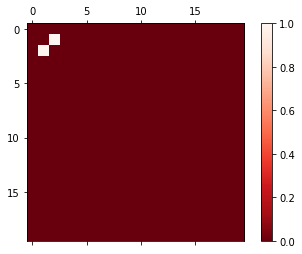

In [25]:
import numpy
# correlations = data.corr()  #计算变量之间的相关系数矩阵
# plot correlation matrix
fig = plt.figure() #调用figure创建一个绘图对象
ax = fig.add_subplot(111)
cax = ax.matshow(adj[0:20,0:20], vmin=0, vmax=1, cmap='Reds_r')  #绘制热力图，从-1到1
fig.colorbar(cax)  #将matshow生成热力图设置为颜色渐变条
ticks = numpy.arange(0,9,1) #生成0-9，步长为1
plt.savefig('/home/lifuzhen/gcn/unrefined.eps')
plt.show()

In [ ]:
proj = TSNE(random_state=1,perplexity=10,early_exaggeration=12,init='random').fit_transform(encoded_node_1)
    
y = onehot2index(load_data(dataset)[8])
scatter(proj, y)
plt.show()

In [12]:
(-np.sort(-adj)).tolist()[0]

[1.0,
 1.0,
 1.0,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074505806,
 0.05000000074

In [ ]:
encoded_node_1

In [13]:
(-np.sort(-adj_learn)).tolist()[0]

[1.0,
 0.9999995827674866,
 0.9999993443489075,
 0.9999988675117493,
 0.9999983906745911,
 0.9999983310699463,
 0.999998152256012,
 0.9999977946281433,
 0.9999976754188538,
 0.999997615814209,
 0.9999975562095642,
 0.9999970197677612,
 0.9999967813491821,
 0.9999963045120239,
 0.9999955892562866,
 0.9999954104423523,
 0.9999950528144836,
 0.9999948740005493,
 0.9999948740005493,
 0.9999946355819702,
 0.9999945163726807,
 0.9999944567680359,
 0.9999940395355225,
 0.9999933838844299,
 0.9999933838844299,
 0.9999930262565613,
 0.9999924302101135,
 0.9999921917915344,
 0.9999921917915344,
 0.9999921321868896,
 0.9999919533729553,
 0.9999918341636658,
 0.999991774559021,
 0.9999910593032837,
 0.9999909400939941,
 0.9999907612800598,
 0.9999905824661255,
 0.9999901652336121,
 0.9999898076057434,
 0.9999897480010986,
 0.9999896883964539,
 0.9999889731407166,
 0.9999880790710449,
 0.9999880790710449,
 0.9999878406524658,
 0.9999877214431763,
 0.9999876022338867,
 0.9999873042106628,
 0.9999871

In [ ]:
adj_delta[index_alter_N]

In [ ]:
print('平均准确率：%f'%(sum(acc)/len(acc)))

In [ ]:
type(sum(acc)/len(acc))

In [ ]:
np.where(adj.toarray() == 6.0)

# 降噪+L1正则

In [ ]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF

# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)

KTF.set_session(sess)

dataset = 'cora'  #citeseer   cora  pubmed

feature = load_data(dataset)[1].toarray()
feature_noise = feature + 0.3*np.random.normal(loc=0.0, scale= 1.0, size= feature.shape)
feature_noise = np.clip(feature_noise, 0, 1)
# original_train, original_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
# x_train, x_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
y_train = load_data(dataset)[2][load_data(dataset)[5]].tolist()
####自带邻接矩阵
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj + sp.eye(adj.shape[0]))
# adj_normalize_tf = tf.convert_to_tensor(adj_normalize.toarray(),dtype='float32')
#####逼近式
alpha = 0.9
adj = load_data(dataset)[0]
adj_normalize = normalize_adj(adj)
adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)
adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')

encoding_dim_1 = 512
encoding_dim_2 = 512
encoding_dim_3 = 512


order_0 = Input(shape=(feature.shape[1],)) 

def graph_convex(x):
    x1 = K.dot(adj_normalize_tf,x)
    return x1

###########不对称
order_1 = Lambda(function=graph_convex)(order_0)
encoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_1)  
# encoded_1 = Dropout(0.5)(encoded_1)
# encoded_1 = BatchNormalization(axis = -1)(encoded_1)

order_2 = Lambda(function= graph_convex)(encoded_1)
encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(order_2)  
# encoded_2 = Dropout(0.5)(encoded_2)
# encoded_2 = BatchNormalization(axis = -1)(encoded_2)

order_3 = Lambda(function= graph_convex)(encoded_2)
encoded_3 = Dense(encoding_dim_3, activation='tanh', use_bias=True)(order_3)  
# encoded_2 = Dropout(0.5)(encoded_2)
encoded_3 = BatchNormalization(axis = -1)(encoded_3)

order_4 = Lambda(function= graph_convex)(encoded_3)
decoded_1 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(order_4)  
# decoded_1 = Dropout(0.5)(decoded_1)
# decoded_1 = BatchNormalization(axis = -1)(decoded_1)

order_5 = Lambda(function= graph_convex)(decoded_1)
decoded_2 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_5)  
# decoded_1 = Dropout(0.5)(decoded_1)
# decoded_2 = BatchNormalization(axis = -1)(decoded_2)

order_6 = Lambda(function= graph_convex)(decoded_2)
decoded_3 = Dense(feature.shape[1], activation='tanh', use_bias=True)(order_6)  
# decoded_2 = Dense(feature.shape[1], activation='sigmoid', use_bias=True, activity_regularizer=regularizers.l1(10e-7))(order_4)  
# decoded_2 = BatchNormalization(axis = -1)(decoded_2)

autoencoder = Model(inputs=order_0, outputs=decoded_3)  
encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
encoder_3 = Model(inputs=order_0, outputs=encoded_3)
decoder_1 = Model(inputs=order_0, outputs=decoded_1)
decoder_2 = Model(inputs=order_0, outputs=decoded_2)



adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
autoencoder.fit(feature, feature, epochs=5000,batch_size=feature.shape[0],shuffle=False)




In [ ]:
K.clear_session()

# 图传递

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/300
3327/3327 [==============================] - 1s 271us/step - loss: 0.9915
Epoch 2/300
3327/3327 [==============================] - 0s 70us/step - loss: 0.9504
Epoch 3/300
3327/3327 [==============================] - 0s 77us/step - loss: 0.9133
Epoch 4/300
3327/3327 [==============================] - 0s 57us/step - loss: 0.8787
Epoch 5/300
3327/3327 [==============================] - 0s 53us/step - loss: 0.8462
Epoch 6/300
3327/3327 [==============================] - 0s 52us/step - loss: 0.8161
Epoch 7/300
3327/3327 [==============================] - 0s 58us/step - loss: 0.7888
Epoch 8/300
3327/3327 [==============================] - 0s 67us/step - loss: 0.7636
Epoch 9/300
3327/3327 [==============================] - 0s 74us/step - loss: 0.7391
Epoch 10/300
3327/3327 [==============================] - 0s 55us/step - loss: 0.7151
Epoch 11/300
3327/3327 [==============================] - 0s 54us/step - loss: 0.6921
Epoch 12/300
3327/3327 [==============================] - 0s 5

Epoch 97/300
3327/3327 [==============================] - 0s 70us/step - loss: 0.0347
Epoch 98/300
3327/3327 [==============================] - 0s 57us/step - loss: 0.0344
Epoch 99/300
3327/3327 [==============================] - 0s 54us/step - loss: 0.0341
Epoch 100/300
3327/3327 [==============================] - 0s 54us/step - loss: 0.0338
Epoch 101/300
3327/3327 [==============================] - 0s 65us/step - loss: 0.0336
Epoch 102/300
3327/3327 [==============================] - 0s 55us/step - loss: 0.0333
Epoch 103/300
3327/3327 [==============================] - 0s 72us/step - loss: 0.0331
Epoch 104/300
3327/3327 [==============================] - 0s 55us/step - loss: 0.0328
Epoch 105/300
3327/3327 [==============================] - 0s 54us/step - loss: 0.0326
Epoch 106/300
3327/3327 [==============================] - 0s 56us/step - loss: 0.0323
Epoch 107/300
3327/3327 [==============================] - 0s 56us/step - loss: 0.0321
Epoch 108/300
3327/3327 [=====================

Epoch 192/300
3327/3327 [==============================] - 0s 56us/step - loss: 0.0224
Epoch 193/300
3327/3327 [==============================] - 0s 55us/step - loss: 0.0224
Epoch 194/300
3327/3327 [==============================] - 0s 56us/step - loss: 0.0223
Epoch 195/300
3327/3327 [==============================] - 0s 54us/step - loss: 0.0222
Epoch 196/300
3327/3327 [==============================] - 0s 55us/step - loss: 0.0222
Epoch 197/300
3327/3327 [==============================] - 0s 51us/step - loss: 0.0221
Epoch 198/300
3327/3327 [==============================] - 0s 52us/step - loss: 0.0220
Epoch 199/300
3327/3327 [==============================] - 0s 51us/step - loss: 0.0220
Epoch 200/300
3327/3327 [==============================] - 0s 50us/step - loss: 0.0219
Epoch 201/300
3327/3327 [==============================] - 0s 49us/step - loss: 0.0219
Epoch 202/300
3327/3327 [==============================] - 0s 54us/step - loss: 0.0218
Epoch 203/300
3327/3327 [==================

Epoch 287/300
3327/3327 [==============================] - 0s 77us/step - loss: 0.0180
Epoch 288/300
3327/3327 [==============================] - 0s 55us/step - loss: 0.0180
Epoch 289/300
3327/3327 [==============================] - 0s 61us/step - loss: 0.0179
Epoch 290/300
3327/3327 [==============================] - 0s 58us/step - loss: 0.0179
Epoch 291/300
3327/3327 [==============================] - 0s 57us/step - loss: 0.0179
Epoch 292/300
3327/3327 [==============================] - 0s 56us/step - loss: 0.0179
Epoch 293/300
3327/3327 [==============================] - 0s 57us/step - loss: 0.0179
Epoch 294/300
3327/3327 [==============================] - 0s 65us/step - loss: 0.0180
Epoch 295/300
3327/3327 [==============================] - 0s 78us/step - loss: 0.0186
Epoch 296/300
3327/3327 [==============================] - 0s 76us/step - loss: 0.0186
Epoch 297/300
3327/3327 [==============================] - 0s 74us/step - loss: 0.0184
Epoch 298/300
3327/3327 [==================

100%|██████████| 1/1 [01:09<00:00, 69.40s/it]

SVC_auc：0.709000
GBDT_auc：0.555000
RF_auc：0.599000
KNN_auc:0.694000
0.694
0.0


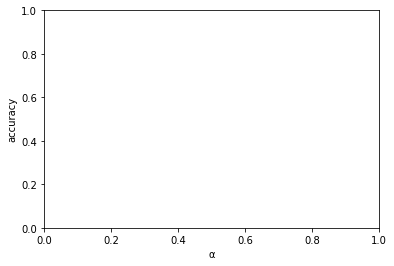

In [41]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF
K.clear_session()
# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)

KTF.set_session(sess)

selec = [0.75]
ACC = []
for alpha in selec:
    acc = []
    for n in tqdm(range(1)):
        dataset = 'citeseer'  #citeseer   cora  pubmed

        feature = load_data(dataset)[1].toarray()
        # original_train, original_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
        # x_train, x_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
        y_train = load_data(dataset)[2][load_data(dataset)[5]].tolist()
        ####自带邻接矩阵
    #     adj = load_data(dataset)[0]
    #     adj_normalize = normalize_adj(adj) + sp.eye(adj.shape[0])
    #     adj_normalize_tf = tf.convert_to_tensor(adj_normalize.toarray(),dtype='float32')
        #####逼近式
    #     alpha = 0.85
        adj = load_data(dataset)[0]
#         adj = np.zeros([feature.shape[0],feature.shape[0]])
#         for i in range(feature.shape[0]):
#             adj[i] = np.dot(feature/np.sqrt(np.sum(np.square(feature),axis=1,keepdims=True)),feature[i]/np.sqrt(np.sum(np.square(feature[i]))))
#         adj = np.zeros([feature.shape[0],feature.shape[0]])
#         for i in range(feature.shape[0]):
#             adj[i] = np.exp(-np.mean( np.square(encoded_node_1 - encoded_node_1[i]) ,axis=1))
       
        adj_normalize = normalize_adj(adj)
        adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - alpha*adj_normalize.toarray())
        # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)
        adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')
    #     #####逼近式
    #     alpha = 0.75
    #     adj = load_data(dataset)[0]
    #     adj_normalize = normalize_adj(adj)
    #     adj_normalize = np.eye(adj.shape[0])*np.dot(adj_normalize.toarray(),adj_normalize.toarray()) + \
    #     np.dot(alpha*adj_normalize.toarray(),np.linalg.inv(np.eye(adj.shape[0]) - alpha*adj_normalize.toarray()))
    #     # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)
    #     adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')
        #####逼近式
    #     alpha = 0.9
    #     adj = load_data(dataset)[0]
    #     adj_normalize = normalize_adj(adj)
    #     adj_normalize = np.eye(adj.shape[0]) + np.dot(alpha*adj_normalize.toarray(), np.linalg.inv(np.eye(adj.shape[0]) - alpha*alpha*np.dot(adj_normalize.toarray(),adj_normalize.toarray()))) ##citeseer 0.75 cora0.9 pubmed 0.95
    #     # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)
    #     adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')

        ######penalty of degree
#         adj_tf = tf.convert_to_tensor(adj.toarray(), dtype='float32')
#         C = adj_tf + K.dot(adj_tf, adj_tf) - K.dot(adj_tf, adj_tf)*K.eye(feature.shape[0])
#         D = K.dot(adj_tf, adj_tf)*K.eye(feature.shape[0])  ##degree matrix
#         D_pow = K.pow(D + 1e-10, -2)*K.eye(feature.shape[0])

#         D_norm = K.pow(D + 1e-20, -0.5)*K.eye(feature.shape[0]) ####D^-0.5
#         W = K.dot(K.dot(D_pow, C), D_pow)
#         W = K.dot(K.dot(D_norm, W), D_norm)
#         L = K.eye(feature.shape[0]) - W
#         L = K.eval(L)
#         L = normalize_adj(L).toarray()
#         L[np.where(np.isnan(L))] = 0.
#         L = tf.convert_to_tensor(L, dtype='float32')
        ###高斯核邻接矩阵
        # t = 3
        # adj = np.zeros([feature.shape[0],feature.shape[0]])
        # for i in range(feature.shape[0]):
        #     adj[i] = np.exp(-np.sum(np.square(feature - feature[i])/2/t ,axis=1))

        # adj_normalize = normalize_adj(adj)
        # adj_normalize_tf = tf.convert_to_tensor(adj_normalize.toarray(),dtype='float32')
        ####citeseer########
        # encoding_dim_1 = 2048
        # encoding_dim_2 = 512
        ####cora #######
        encoding_dim_1 = 1024
        encoding_dim_2 = 512
        ######pubmed#####
        # encoding_dim_1 = 128
        # encoding_dim_2 = 128

        order_0 = Input(shape=(feature.shape[1],)) 

        def graph_convex(x):
            x1 = K.dot(adj_normalize_tf,x)
            return x1

        ###########不对称
        order_1 = Lambda(function=graph_convex)(order_0)
#         encoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_1)  
#         # encoded_1 = Dropout(0.5)(encoded_1)
#         encoded_1 = BatchNormalization(axis = -1)(encoded_1)

        order_2 = Lambda(function= graph_convex)(order_1)
        encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(order_2)  
        # encoded_2 = Dropout(0.5)(encoded_2)
        encoded_22 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_2 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_2 = Lambda(function= graph_convex)(encoded_2)
#         encoded_2 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_2)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_2)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)
        
#         encoded_22 = Lambda(function= graph_convex)(encoded_22)
#         encoded_22 = Dense(encoding_dim_2, activation='tanh', use_bias=True)(encoded_22)  
#         # encoded_2 = Dropout(0.5)(encoded_2)
#         encoded_22 = BatchNormalization(axis = -1)(encoded_22)

#         order_3 = Lambda(function= graph_convex)(encoded_22)
#         decoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(order_3)  
#         # decoded_1 = Dropout(0.5)(decoded_1)
#         decoded_1 = BatchNormalization(axis = -1)(decoded_1)

        order_4 = Lambda(function= graph_convex)(encoded_22)
        decoded_2 = Dense(feature.shape[1], activation='sigmoid', use_bias=True)(order_4)  
    #     decoded_2 = BatchNormalization(axis = -1)(decoded_2)


        def myloss(y_true, y_pred, e= 1e-4):
                recon = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
#                 trace = K.sum(K.dot(K.dot(K.transpose(encoded_2), L), encoded_2) * K.eye(encoding_dim_2))/encoding_dim_2
                return recon


        ############对称
        # order_1 = Lambda(function=graph_convex)(order_0)
        # encoded_1M = Dense(encoding_dim_1, activation='tanh', use_bias=False)
        # encoded_1 = encoded_1M(order_1) 
        # # encoded_1 = Dropout(0.5)(encoded_1)
        # encoded_1 = BatchNormalization(axis = -1)(encoded_1)

        # order_2 = Lambda(function= graph_convex)(encoded_1)
        # encoded_2M = Dense(encoding_dim_2, activation='tanh', use_bias=False)
        # encoded_2 = encoded_2M(order_2)
        # # encoded_2 = Dropout(0.5)(encoded_2)
        # encoded_2 = BatchNormalization(axis = -1)(encoded_2)

        # order_3 = Lambda(function= graph_convex)(encoded_2)
        # decoded_1 = Lambda(lambda x: K.tanh(K.dot(x,K.variable(np.transpose(encoded_2M.get_weights()[0]),dtype='float32'))))(order_3)  
        # # decoded_1 = Dropout(0.5)(decoded_1)
        # decoded_1 = BatchNormalization(axis = -1)(decoded_1)

        # order_4 = Lambda(function= graph_convex)(decoded_1)
        # decoded_2 = Lambda(lambda x: K.tanh(K.dot(x,K.variable(np.transpose(encoded_1M.get_weights()[0]),dtype='float32'))))(order_4)  
        # decoded_2 = BatchNormalization(axis = -1)(decoded_2)

        ###############直接用关系矩阵###########
        # order_0 = Input(shape=(adj_normalize.shape[1],)) 
        # def graph_convex(x):
        #     x1 = x
        #     return x1
        # order_1 = Lambda(function=graph_convex)(order_0)
        # encoded_1M = Dense(encoding_dim_1, activation='tanh', use_bias=False)
        # encoded_1 = encoded_1M(order_1) 
        # # encoded_1 = Dropout(0.5)(encoded_1)
        # encoded_1 = BatchNormalization(axis = -1)(encoded_1)

        # order_2 = Lambda(function= graph_convex)(encoded_1)
        # encoded_2M = Dense(feature.shape[1], activation='tanh', use_bias=False)
        # encoded_2 = encoded_2M(order_2)
        # # encoded_2 = Dropout(0.5)(encoded_2)
        # encoded_2 = BatchNormalization(axis = -1)(encoded_2)

        # order_3 = Lambda(function= graph_convex)(encoded_2)
        # decoded_1 = Lambda(lambda x: K.tanh(K.dot(x,K.variable(np.transpose(encoded_2M.get_weights()[0]),dtype='float32'))))(order_3)  
        # # decoded_1 = Dropout(0.5)(decoded_1)
        # decoded_1 = BatchNormalization(axis = -1)(decoded_1)

        # order_4 = Lambda(function= graph_convex)(decoded_1)
        # decoded_2 = Lambda(lambda x: K.tanh(K.dot(x,K.variable(np.transpose(encoded_1M.get_weights()[0]),dtype='float32'))))(order_4)  
        # decoded_2 = BatchNormalization(axis = -1)(decoded_2)
        # def myloss(x):
        #     t = 1
        #     size = adj_normalize.shape[0]
        #     CE1, CE2, CE3 = 0, 0, 0
        #     for i in range(size):
        #         for j in range(i,size):
        #             CE1 += K.binary_crossentropy(K.exp(-K.sum(K.square(K.gather(x[0],i) - K.gather(x[0], j)))/2.0/t), adj_normalize_tf[i,j])
        #             CE2 += K.binary_crossentropy(K.exp(-K.sum(K.square(K.gather(x[1],i) - K.gather(x[1], j)))/2.0/t), adj_normalize_tf[i,j])
        #             CE3 += K.binary_crossentropy(K.exp(-K.sum(K.square(K.gather(x[2],i) - K.gather(x[2], j)))/2.0/t), adj_normalize_tf[i,j])
        #     CE4 = K.sum(K.binary_crossentropy(x[3],x[4]))
        #     return CE1 + CE2 + CE3 + CE4

        # def myloss(x):
        #     CE1 = K.mean(K.binary_crossentropy(K.dot(x[0] , K.transpose(x[0])), adj_normalize_tf))
        #     CE2 = K.mean(K.binary_crossentropy(K.dot(x[1] , K.transpose(x[1])), adj_normalize_tf))
        #     CE3 = K.mean(K.binary_crossentropy(K.dot(x[2] , K.transpose(x[2])), adj_normalize_tf))
        #     CE4 = K.mean(K.binary_crossentropy(x[3],x[4]))
        #     return CE1 + CE2 + CE3 + CE4
        # def myloss(x):
        #     t = 1
        #     adj_1 = K.exp(-K.sum(K.square(x[0] - K.reshape(x[0], [K.int_shape(x[0])[0],1,K.int_shape(x[0])[1]])),axis=-1)/2.0/t)
        #     adj_2 = K.exp(-K.sum(K.square(x[1] - K.reshape(x[1], [K.int_shape(x[1])[0],1,K.int_shape(x[1])[1]])),axis=-1)/2.0/t)
        #     adj_3 = K.exp(-K.sum(K.square(x[2] - K.reshape(x[2], [K.int_shape(x[2])[0],1,K.int_shape(x[2])[1]])),axis=-1)/2.0/t)

        #     return K.mean(K.binary_crossentropy(adj_1 , adj_normalize_tf)) + K.mean(K.binary_crossentropy(adj_2 , adj_normalize_tf)) + K.mean(K.binary_crossentropy(adj_3 , adj_normalize_tf)) + K.mean(K.binary_crossentropy(x[3] , K.variable(feature,dtype='float32')))

        # t = 1
        # Loss = Lambda(lambda x :K.mean(K.binary_crossentropy(K.exp(-K.sum(K.square(x[0] - K.reshape(x[0], [K.int_shape(x[0])[0],1,K.int_shape(x[0])[1]])),axis=-1)/2.0/t) , adj_normalize_tf))\
        #                          +K.mean(K.binary_crossentropy(K.exp(-K.sum(K.square(x[1] - K.reshape(x[1], [K.int_shape(x[1])[0],1,K.int_shape(x[1])[1]])),axis=-1)/2.0/t) , adj_normalize_tf))\
        #                         +K.mean(K.binary_crossentropy(K.exp(-K.sum(K.square(x[2] - K.reshape(x[2], [K.int_shape(x[2])[0],1,K.int_shape(x[2])[1]])),axis=-1)/2.0/t) , adj_normalize_tf))\
        #                         +K.mean(K.binary_crossentropy(x[3],x[4])) )([encoded_1,encoded_2,decoded_1,decoded_2,order_0])
        # Loss = Lambda(function=myloss)([encoded_1,encoded_2,decoded_1,decoded_2,order_0])
        # def myloss(y_true, y_pred):
        #     y_true = K.clip(y_true, K.epsilon(), 1)
        #     y_pred = K.clip(y_pred, K.epsilon(), 1)
        #     return K.sum(y_true * K.log(y_true / y_pred), axis=-1) + 
        autoencoder = Model(inputs=order_0, outputs=decoded_2)  
#         encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
        encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
#         decoder_1 = Model(inputs=order_0, outputs=decoded_1)



        #####结构保持loss + 重构loss############
        # autoencoder.compile(optimizer='Adam', loss=lambda y_true,y_pred:y_pred)
        ########重构loss#################
        adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        autoencoder.compile(optimizer=adam, loss=myloss)
        autoencoder.fit(feature, feature, epochs=300,batch_size=feature.shape[0],shuffle=False, verbose=1)
        ##cora: 50  citeseer:   pubmed: 

        ########三层########
        # encoder_2.compile(optimizer=adam , loss='binary_crossentropy')
        # encoder_2.fit(feature, feature, epochs=300,batch_size=feature.shape[0],shuffle=False)
        from sklearn.svm import SVC
        from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
        from sklearn.ensemble.forest import RandomForestClassifier
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn import metrics
        def onehot2index(onehot):
            index = []
            onehot = onehot.tolist()
            for i in onehot:
                index.append(i.index(1))
            return np.array(index)

        trainX , trainY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
        testX, testY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

        # trainX , trainY = proj[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
        # testX, testY = proj[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])


        svc = SVC(C=3,kernel='rbf')#cora 1.7 citeseer 3
        gbdt = GradientBoostingClassifier(n_estimators=8)
        rf = RandomForestClassifier()
        knn = KNeighborsClassifier()

        svc.fit(trainX, trainY)
        gbdt.fit(trainX, trainY)
        rf.fit(trainX, trainY)
        knn.fit(trainX,trainY)

        pred_SVC = svc.predict(testX)
        pred_GBDT = gbdt.predict(testX)
        pred_RF = rf.predict(testX)
        pred_KNN = knn.predict(testX)

        auc_SVC = metrics.accuracy_score(testY , pred_SVC)
        auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
        auc_RF = metrics.accuracy_score(testY , pred_RF)
        auc_KNN = metrics.accuracy_score(testY , pred_KNN)

        print('SVC_auc：%f'%auc_SVC)
        print('GBDT_auc：%f'%auc_GBDT)
        print('RF_auc：%f'%auc_RF)
        print('KNN_auc:%f'%auc_KNN)
        acc.append(auc_KNN)

    print(np.mean(acc))
    print(np.std(acc))
    ACC.append(np.mean(acc))
    
plt.plot(selec,ACC)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('α')
plt.ylabel('accuracy')
plt.show()

In [11]:
np.sort(adj)

array([[0.        , 0.        , 0.        , ..., 0.38490018, 0.5       ,
        1.00000012],
       [0.        , 0.        , 0.        , ..., 0.31277162, 0.41702884,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.3441236 , 0.41039133,
        0.99999994],
       ...,
       [0.        , 0.        , 0.        , ..., 0.33333334, 0.38490018,
        1.00000012],
       [0.        , 0.        , 0.        , ..., 0.36788359, 0.37796447,
        0.99999988],
       [0.        , 0.        , 0.        , ..., 0.32025629, 0.3721042 ,
        1.        ]])

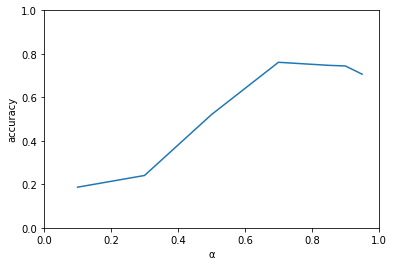

In [7]:
plt.plot(selec,ACC1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('α')
plt.ylabel('accuracy')
plt.savefig('/home/lifuzhen/gcn/sensitivity.eps')
plt.show()

In [ ]:
K.eval(L)[0,1166]

In [ ]:
np.where(np.isnan(L.toarray()))

# Encoder1

In [ ]:
encoded_node_1 = encoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]

from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(encoded_node_1)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

trainX , trainY = encoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = encoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

# trainX , trainY = proj[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
# testX, testY = proj[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

svc = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
gbdt = GradientBoostingClassifier(n_estimators=9)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

svc.fit(trainX, trainY)
gbdt.fit(trainX, trainY)
rf.fit(trainX, trainY)
knn.fit(trainX,trainY)

pred_SVC = svc.predict(testX)
pred_GBDT = gbdt.predict(testX)
pred_RF = rf.predict(testX)
pred_KNN = knn.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
for i in range(100):
    autoencoder.fit(feature, feature, epochs=10,batch_size=feature.shape[0],shuffle=False,verbose=0)
    trainX , trainY = encoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = encoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    svc = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
    gbdt = GradientBoostingClassifier(n_estimators=8)
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier(n_neighbors=6)

    svc.fit(trainX, trainY)
    gbdt.fit(trainX, trainY)
    rf.fit(trainX, trainY)
    knn.fit(trainX,trainY)

    pred_SVC = svc.predict(testX)
    pred_GBDT = gbdt.predict(testX)
    pred_RF = rf.predict(testX)
    pred_KNN = knn.predict(testX)

    auc_SVC = metrics.accuracy_score(testY , pred_SVC)
    auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
    auc_RF = metrics.accuracy_score(testY , pred_RF)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    
    print('第%d次循环：'%(i+1))
    print('SVC_auc：%f'%auc_SVC)
    print('GBDT_auc：%f'%auc_GBDT)
    print('RF_auc：%f'%auc_RF)
    print('KNN_auc:%f'%auc_KNN)

# Encoder2

[[0.86       0.3712     0.34      ]
 [0.86       0.81691429 0.34      ]
 [0.45737143 0.86       0.34      ]
 [0.34       0.86       0.66834286]
 [0.34       0.60594286 0.86      ]
 [0.51977143 0.34       0.86      ]
 [0.86       0.34       0.75451429]]


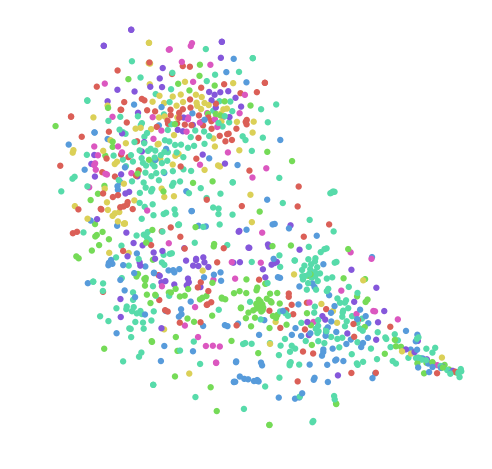

In [9]:
encoded_node_2 = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]

from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(encoded_node_2)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

trainX , trainY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

# trainX , trainY = proj[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
# testX, testY = proj[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])


svc = SVC(C=3,kernel='rbf')#cora 1.7 citeseer 3
gbdt = GradientBoostingClassifier(n_estimators=8)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

svc.fit(trainX, trainY)
gbdt.fit(trainX, trainY)
rf.fit(trainX, trainY)
knn.fit(trainX,trainY)

pred_SVC = svc.predict(testX)
pred_GBDT = gbdt.predict(testX)
pred_RF = rf.predict(testX)
pred_KNN = knn.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
maximum = 0
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
for i in tqdm(range(50)):
    autoencoder.fit(feature, feature, epochs=20,batch_size=feature.shape[0],shuffle=False,verbose=0)
    trainX , trainY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    svc = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
    gbdt = GradientBoostingClassifier(n_estimators=8)
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()

    svc.fit(trainX, trainY)
    gbdt.fit(trainX, trainY)
    rf.fit(trainX, trainY)
    knn.fit(trainX,trainY)

    pred_SVC = svc.predict(testX)
    pred_GBDT = gbdt.predict(testX)
    pred_RF = rf.predict(testX)
    pred_KNN = knn.predict(testX)

    auc_SVC = metrics.accuracy_score(testY , pred_SVC)
    auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
    auc_RF = metrics.accuracy_score(testY , pred_RF)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    
    maximum = max(auc_KNN , maximum)
    
    print('第%d次循环：'%(i+1))
    print('SVC_auc：%f'%auc_SVC)
    print('GBDT_auc：%f'%auc_GBDT)
    print('RF_auc：%f'%auc_RF)
    print('KNN_auc:%f'%auc_KNN)
    
print('最高准确率为:%f'%maximum)

# Encoder3

In [ ]:
encoded_node_3 = encoder_3.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]

from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(encoded_node_3)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

# trainX , trainY = encoder_3.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
# testX, testY = encoder_3.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

trainX , trainY = proj[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = proj[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])



svc = SVC(C=3,kernel='rbf')#cora 1.7 citeseer 3
gbdt = GradientBoostingClassifier(n_estimators=8)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

svc.fit(trainX, trainY)
gbdt.fit(trainX, trainY)
rf.fit(trainX, trainY)
knn.fit(trainX,trainY)

pred_SVC = svc.predict(testX)
pred_GBDT = gbdt.predict(testX)
pred_RF = rf.predict(testX)
pred_KNN = knn.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
for i in range(100):
    autoencoder.fit(feature, feature, epochs=10,batch_size=feature.shape[0],shuffle=False,verbose=0)
    trainX , trainY = encoder_3.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = encoder_3.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    svc = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
    gbdt = GradientBoostingClassifier(n_estimators=8)
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier(n_neighbors=6)

    svc.fit(trainX, trainY)
    gbdt.fit(trainX, trainY)
    rf.fit(trainX, trainY)
    knn.fit(trainX,trainY)

    pred_SVC = svc.predict(testX)
    pred_GBDT = gbdt.predict(testX)
    pred_RF = rf.predict(testX)
    pred_KNN = knn.predict(testX)

    auc_SVC = metrics.accuracy_score(testY , pred_SVC)
    auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
    auc_RF = metrics.accuracy_score(testY , pred_RF)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    
    print('第%d次循环：'%(i+1))
    print('SVC_auc：%f'%auc_SVC)
    print('GBDT_auc：%f'%auc_GBDT)
    print('RF_auc：%f'%auc_RF)
    print('KNN_auc:%f'%auc_KNN)

# Decoder1

In [ ]:
decoded_node_1 = decoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]

from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(decoded_node_1)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

trainX , trainY = decoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = decoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

# trainX , trainY = proj[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
# testX, testY = proj[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])


svc = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
gbdt = GradientBoostingClassifier(n_estimators=8)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

svc.fit(trainX, trainY)
gbdt.fit(trainX, trainY)
rf.fit(trainX, trainY)
knn.fit(trainX,trainY)

pred_SVC = svc.predict(testX)
pred_GBDT = gbdt.predict(testX)
pred_RF = rf.predict(testX)
pred_KNN = knn.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
for i in range(100):
    autoencoder.fit(feature, feature, epochs=10,batch_size=feature.shape[0],shuffle=False,verbose=0)
    trainX , trainY = decoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = decoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    svc = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
    gbdt = GradientBoostingClassifier(n_estimators=8)
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier(n_neighbors=6)

    svc.fit(trainX, trainY)
    gbdt.fit(trainX, trainY)
    rf.fit(trainX, trainY)
    knn.fit(trainX,trainY)

    pred_SVC = svc.predict(testX)
    pred_GBDT = gbdt.predict(testX)
    pred_RF = rf.predict(testX)
    pred_KNN = knn.predict(testX)

    auc_SVC = metrics.accuracy_score(testY , pred_SVC)
    auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
    auc_RF = metrics.accuracy_score(testY , pred_RF)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    
    print('第%d次循环：'%(i+1))
    print('SVC_auc：%f'%auc_SVC)
    print('GBDT_auc：%f'%auc_GBDT)
    print('RF_auc：%f'%auc_RF)
    print('KNN_auc:%f'%auc_KNN)

# Decoder2

In [ ]:
decoded_node_2 = decoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]

from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(decoded_node_2)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

trainX , trainY = proj[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = proj[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

svc = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
gbdt = GradientBoostingClassifier(n_estimators=8)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

svc.fit(trainX, trainY)
gbdt.fit(trainX, trainY)
rf.fit(trainX, trainY)
knn.fit(trainX,trainY)

pred_SVC = svc.predict(testX)
pred_GBDT = gbdt.predict(testX)
pred_RF = rf.predict(testX)
pred_KNN = knn.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
for i in range(100):
    autoencoder.fit(feature, feature, epochs=10,batch_size=feature.shape[0],shuffle=False,verbose=0)
    trainX , trainY = decoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = decoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    svc = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
    gbdt = GradientBoostingClassifier(n_estimators=8)
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier(n_neighbors=6)

    svc.fit(trainX, trainY)
    gbdt.fit(trainX, trainY)
    rf.fit(trainX, trainY)
    knn.fit(trainX,trainY)

    pred_SVC = svc.predict(testX)
    pred_GBDT = gbdt.predict(testX)
    pred_RF = rf.predict(testX)
    pred_KNN = knn.predict(testX)

    auc_SVC = metrics.accuracy_score(testY , pred_SVC)
    auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
    auc_RF = metrics.accuracy_score(testY , pred_RF)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    
    print('第%d次循环：'%(i+1))
    print('SVC_auc：%f'%auc_SVC)
    print('GBDT_auc：%f'%auc_GBDT)
    print('RF_auc：%f'%auc_RF)
    print('KNN_auc:%f'%auc_KNN)

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
for i in range(100):
    autoencoder.fit(feature, feature, epochs=10,batch_size=feature.shape[0],shuffle=False,verbose=0)
    trainX_1 , trainY_1 = encoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX_1, testY_1 = encoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])
    trainX_2 , trainY_2 = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX_2, testY_2 = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])
    trainX_3 , trainY_3 = decoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX_3, testY_3 = decoder_1.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])
    
    svc_1 = SVC(C=1.7,kernel='rbf')#cora 1.7 citeseer 3
    svc_2 = SVC(C=1.7,kernel='rbf')
    svc_3 = SVC(C=1.7,kernel='rbf')
    
    svc_1.fit(trainX_1, trainY_1)
    svc_2.fit(trainX_2, trainY_2)
    svc_3.fit(trainX_3, trainY_3)

    pred_SVC_1 = svc_1.predict(testX_1)
    pred_SVC_2 = svc_2.predict(testX_2)
    pred_SVC_3 = svc_3.predict(testX_3)

    auc_SVC_1 = metrics.accuracy_score(testY_1 , pred_SVC_1)
    auc_SVC_2 = metrics.accuracy_score(testY_2 , pred_SVC_2)
    auc_SVC_3 = metrics.accuracy_score(testY_3 , pred_SVC_3)
    
    print('第%d次循环：'%(i+1))
    print('SVC_auc_1：%f'%auc_SVC_1)
    print('SVC_auc_2：%f'%auc_SVC_2)
    print('SVC_auc_3：%f'%auc_SVC_3)

# 没有图传递

In [ ]:
from keras.layers import Input, Dense  ,Dot ,Lambda ,BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF

# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

KTF.set_session(sess)
acc = []
for n in range(1):
    dataset = 'cora'  #citeseer   cora  pubmed

    feature = load_data(dataset)[1].toarray()
    # original_train, original_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
    # x_train, x_test = feature[load_data(dataset)[5]], feature[load_data(dataset)[7]]
    y_train = load_data(dataset)[2][load_data(dataset)[5]].tolist()
    t = 1
    ####citeseer########
    # encoding_dim_1 = 2048
    # encoding_dim_2 = 512
    ####cora #######
    encoding_dim_1 = 2048
    encoding_dim_2 = 512
    ######pubmed#####
    # encoding_dim_1 = 8
    # encoding_dim_2 = 8

    order_00 = Input(shape=(feature.shape[1],)) 

    # def graph_convex(x):
    #     x1 = x
    #     return x1


    # order_11 = Lambda(function=graph_convex)(order_00)
    encoded_11 = Dense(encoding_dim_1, activation='tanh')(order_00) 
    encoded_11 = BatchNormalization(axis = -1)(encoded_11)

    # order_22 = Lambda(function= graph_convex)(encoded_11)
    encoded_22 = Dense(encoding_dim_2, activation='tanh')(encoded_11)  
    encoded_22 = BatchNormalization(axis = -1)(encoded_22)

    # order_33 = Lambda(function= graph_convex)(encoded_22)
    decoded_11 = Dense(encoding_dim_1, activation='tanh')(encoded_22)  
    decoded_11 = BatchNormalization(axis = -1)(decoded_11)

    # order_44 = Lambda(function= graph_convex)(decoded_11)
    decoded_22 = Dense(feature.shape[1], activation='tanh')(decoded_11)  

    autoencoder_1 = Model(inputs=order_00, outputs=decoded_22)  
    encoder_11 = Model(inputs=order_00, outputs=encoded_11)    
    encoder_22 = Model(inputs=order_00, outputs=encoded_22)
    decoder_11 = Model(inputs=order_00, outputs=decoded_11)

    autoencoder_1.compile(optimizer='Adam', loss='binary_crossentropy')
    autoencoder_1.fit(feature, feature, epochs=300,batch_size=feature.shape[0],shuffle=False)


    from sklearn.svm import SVC
    from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
    from sklearn.ensemble.forest import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import metrics
    def onehot2index(onehot):
        index = []
        onehot = onehot.tolist()
        for i in onehot:
            index.append(i.index(1))
        return np.array(index)
    trainX , trainY = encoder_22.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
    testX, testY = encoder_22.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

    SVC = SVC(C=1,kernel='rbf')
    GBDT = GradientBoostingClassifier(n_estimators=8)
    RF = RandomForestClassifier()
    KNN = KNeighborsClassifier()

    SVC.fit(trainX, trainY)
    GBDT.fit(trainX, trainY)
    RF.fit(trainX, trainY)
    KNN.fit(trainX,trainY)

    pred_SVC = SVC.predict(testX)
    pred_GBDT = GBDT.predict(testX)
    pred_RF = RF.predict(testX)
    pred_KNN = KNN.predict(testX)

    auc_SVC = metrics.accuracy_score(testY , pred_SVC)
    auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
    auc_RF = metrics.accuracy_score(testY , pred_RF)
    auc_KNN = metrics.accuracy_score(testY , pred_KNN)
    
    encoded_node_1 = encoder_22.predict(feature,batch_size=feature.shape[0])

    proj2 = TSNE(random_state=123,perplexity=30,early_exaggeration=12,init='random').fit_transform(encoded_node_1)
    
    y = onehot2index(load_data(dataset)[8])
#     plt.subplot(133)
    scatter(proj2, y)
#     plt.savefig('/home/lifuzhen/gcn/visulization.png')
    plt.show()
    
    print('SVC_auc：%f'%auc_SVC)
    print('GBDT_auc：%f'%auc_GBDT)
    print('RF_auc：%f'%auc_RF)
    print('KNN_auc:%f'%auc_KNN)
    acc.append(auc_KNN)
    
print(np.mean(acc))
print(np.std(acc))

In [ ]:
scatter(proj1,y)
plt.savefig('/home/lifuzhen/gcn/proj1.png')
scatter(proj2,y)
plt.savefig('/home/lifuzhen/gcn/proj2.png')
scatter(proj3,y)
plt.savefig('/home/lifuzhen/gcn/proj3.png')

# 第一层表示

In [ ]:
encoded_node_11 = encoder_11.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]

from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(encoded_node_11)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
trainX , trainY = encoder_11.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = encoder_11.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

SVC = SVC(C=1,kernel='rbf')
GBDT = GradientBoostingClassifier(n_estimators=8)
RF = RandomForestClassifier()
KNN = KNeighborsClassifier(n_neighbors=6)

SVC.fit(trainX, trainY)
GBDT.fit(trainX, trainY)
RF.fit(trainX, trainY)
KNN.fit(trainX,trainY)

pred_SVC = SVC.predict(testX)
pred_GBDT = GBDT.predict(testX)
pred_RF = RF.predict(testX)
pred_KNN = KNN.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

# 第二层表示

In [ ]:
encoded_node_22 = encoder_22.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]

from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(encoded_node_22)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
trainX , trainY = encoder_22.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = encoder_22.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

SVC = SVC(C=1,kernel='rbf')
GBDT = GradientBoostingClassifier(n_estimators=8)
RF = RandomForestClassifier()
KNN = KNeighborsClassifier()

SVC.fit(trainX, trainY)
GBDT.fit(trainX, trainY)
RF.fit(trainX, trainY)
KNN.fit(trainX,trainY)

pred_SVC = SVC.predict(testX)
pred_GBDT = GBDT.predict(testX)
pred_RF = RF.predict(testX)
pred_KNN = KNN.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

# 第三层表示

In [ ]:
decoded_node_11 = decoder_11.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]

from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(decoded_node_11)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
trainX , trainY = decoder_11.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = decoder_11.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

SVC = SVC(C=1,kernel='rbf')
GBDT = GradientBoostingClassifier(n_estimators=8)
RF = RandomForestClassifier()
KNN = KNeighborsClassifier(n_neighbors=6)

SVC.fit(trainX, trainY)
GBDT.fit(trainX, trainY)
RF.fit(trainX, trainY)
KNN.fit(trainX,trainY)

pred_SVC = SVC.predict(testX)
pred_GBDT = GBDT.predict(testX)
pred_RF = RF.predict(testX)
pred_KNN = KNN.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

In [ ]:
# encoded_node = encoder.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]]
encoded_node = encoder.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]]



from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(encoded_node)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
# hot_y = load_data(dataset)[2][load_data(dataset)[5]].tolist()
hot_y = load_data(dataset)[4][load_data(dataset)[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", load_data(dataset)[4].shape[1]))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
#### from keras.layers import Input, Dense  ,Dot ,Lambda
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
import numpy as np  
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm

adj = load_data('citeseer')[0]
adj_normalize = normalize_adj(adj + sp.eye(adj.shape[0]))
feature = load_data('citeseer')[1]
x_train, x_test = adj_normalize.dot(feature)[load_data('citeseer')[5]], adj_normalize.dot(feature)[load_data('citeseer')[7]]
y_train = load_data('citeseer')[2][load_data('citeseer')[5]].tolist()
sample_num = 5 ##随机采样数
margin = 1  ##类间距
encoding_dim_1 = 1024
encoding_dim_2 = 128
input_node = Input(shape=(3703,))  
a_input_node = Input(shape=(3703,)) ##anchor
p_input_node = Input(shape=(3703,))  ##positive
n_input_node = Input(shape=(3703,))  ##negative

encoded_1 = Dense(encoding_dim_1, activation='relu')(input_node)  
encoded_2 = Dense(encoding_dim_2, activation='sigmoid')(encoded_1)  
decoded = Dense(3703, activation='sigmoid')(encoded_2)  

autoencoder = Model(inputs=input_node, outputs=decoded)  
encoder = Model(inputs=input_node, outputs=encoded_2)    

encoded_input = Input(shape=(encoding_dim_2,))  
decoder_layer = autoencoder.layers[-1]  
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input)) 
a_encoded = autoencoder.layers[-2](autoencoder.layers[-3](a_input_node))
p_encoded = autoencoder.layers[-2](autoencoder.layers[-3](p_input_node))
n_encoded = autoencoder.layers[-2](autoencoder.layers[-3](n_input_node))
 
triplet = Lambda(lambda x: K.relu(K.sum(K.square(x[0]-x[1]),1,keepdims=True) - K.sum(K.square(x[0]-x[2]),1,keepdims=True)+ margin))([a_encoded,p_encoded,n_encoded])
triplet_model = Model(inputs= [a_input_node,p_input_node,n_input_node], outputs= triplet)
triplet_model.compile(optimizer='Adam', loss=lambda y_true,y_pred: y_pred)
autoencoder.compile(optimizer='Adam', loss='mse')
for m in tqdm(range(0,10)):
    for j in range(0,6):
        
        C1 = []  ##target and positive
        C2 = []  ##negative
        C = [C1,C2]
        count = 0
        for i in y_train:
            if i.index(1) == j:
                C1.append(x_train[count])
            if i.index(1) != j:
                C2.append(x_train[count])
            count += 1

#         print(x_train.shape)  
#         print(x_test.shape)  
  

#         autoencoder.fit(x_train, x_train, epochs=10, batch_size=32,   
#                         shuffle=True, validation_data=(x_test, x_test))
        for n in range(5):
#             triplet_model.fit([sp.vstack(sample(C1,sample_num)),sp.vstack(sample(C1,sample_num)),sp.vstack(sample(C2,sample_num))],
#                               np.zeros((sample_num,1)), epochs=10, batch_size=10,shuffle=True)
            triplet_model.fit([sp.vstack(sample(C1,sample_num)),sp.vstack(sample(C1,sample_num)),sp.vstack(sample(C2,sample_num))],
                              np.zeros((sample_num,1)), epochs=10)

        


          

encoded_imgs = encoder.predict(x_test)  
decoded_imgs = decoder.predict(encoded_imgs)  



from sklearn.manifold import TSNE
proj = TSNE(random_state=123).fit_transform(encoded_imgs)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data('citeseer')[4][load_data('citeseer')[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 6))
    print(palette)
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
triplet_model.layers

In [ ]:
#### from keras.layers import Input, Dense  ,Dot ,Lambda
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
import numpy as np  
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm

adj = load_data('citeseer')[0]
adj_normalize = normalize_adj(adj + sp.eye(adj.shape[0]))
feature = load_data('citeseer')[1]
x_train, x_test = adj_normalize.dot(adj_normalize).dot(feature)[load_data('citeseer')[5]], adj_normalize.dot(adj_normalize).dot(feature)[load_data('citeseer')[7]]
y_train = load_data('citeseer')[2][load_data('citeseer')[5]].tolist()
sample_num = 4 ##随机采样数
margin = 1  ##类间距
encoding_dim = 1024
lamb = 0.9
a_input_node = Input(shape=(3703,)) ##anchor
p_input_node = Input(shape=(3703,))  ##positive
n_input_node = Input(shape=(3703,))  ##negative

a_encoded = Dense(encoding_dim, activation='sigmoid')(a_input_node)   
p_encoded = Dense(encoding_dim, activation='sigmoid')(p_input_node) 
n_encoded = Dense(encoding_dim, activation='sigmoid')(n_input_node) 
a_decoded = Dense(3703, activation='sigmoid')(a_encoded)  

triplet = Lambda(lambda x: lamb * K.mean(K.sum(K.square(x[4]-x[3]))) + (1 - lamb) * K.maximum(K.sum(K.square(x[0]-x[1])) \
                    - K.sum(K.square(x[0]-x[2]))+ margin,0))([a_encoded,p_encoded,n_encoded,a_decoded,a_input_node])
autoencoder = Model(inputs=[a_input_node,p_input_node,n_input_node], outputs=triplet)  
encoder = Model(inputs=a_input_node, outputs=a_encoded)    

encoded_input = Input(shape=(encoding_dim,))  
decoder_layer = autoencoder.layers[-1]  
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input)) 
autoencoder.compile(optimizer='Adam', loss=lambda y_true,y_pred: y_pred)
C0 = []
C1 = []  ##target and positive
C2 = []  ##negative
C3 = []
C4 = []
C5 = []
C = [C0,C1,C2,C3,C4,C5]
for j in range(0,6):
   
    count = 0
    for i in y_train:
        if i.index(1) == j:
            C[j].append(x_train[count])
        count += 1

for m in tqdm(range(0,10)):
    for n in range(1):
        for j in range(0,6):
            for k in range(0,6):
                if j != k:
                    a = sp.vstack(sample(C[j],sample_num))
                    p = sp.vstack(sample(C[j],sample_num))
                    n = sp.vstack(sample(C[k],sample_num))
    #                 triplet_model.fit([sp.vstack(sample(C[j],sample_num)),sp.vstack(sample(C[j],sample_num)),sp.vstack(sample(C[k],sample_num))],
    #                               np.zeros((sample_num,1)), epochs=20, batch_size=2,shuffle=True)
                    autoencoder.fit([a,p,n],
                                  np.zeros((sample_num,1)), epochs=20, batch_size=2,shuffle=True)

        


          

    encoded_imgs = encoder.predict(x_test)  
    decoded_imgs = decoder.predict(encoded_imgs)  



    from sklearn.manifold import TSNE
    proj = TSNE(random_state=1).fit_transform(encoded_imgs)
    import seaborn as sns
    import matplotlib.patheffects as PathEffects
    y = []
    hot_y = load_data('citeseer')[4][load_data('citeseer')[7]].tolist()
    for i in hot_y:
        y.append(i.index(1))
    y = np.array(y)
    def scatter(x, colors):
        # We choose a color palette with seaborn.
        palette = np.array(sns.color_palette("hls", 6))
        print(y.shape)
        # We create a scatter plot.
        f = plt.figure(figsize=(8, 8))
        ax = plt.subplot(aspect='equal')
        sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                        c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        ax.axis('off')
        ax.axis('tight')
    scatter(proj, y)
    plt.show()

In [ ]:
encoded_imgs = encoder.predict(x_train)  
decoded_imgs = decoder.predict(encoded_imgs)  



from sklearn.manifold import TSNE
proj = TSNE(random_state=1).fit_transform(encoded_imgs)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data('citeseer')[2][load_data('citeseer')[5]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 6))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
scatter(proj, y)
plt.show()

In [ ]:
from keras.layers import Input, Dense  ,Dot
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
import numpy as np  
import matplotlib.pyplot as plt  

adj = load_data('citeseer')[0]
adj_normalize = normalize_adj(adj + sp.eye(adj.shape[0]))
feature = load_data('citeseer')[1]
x_train, x_test = adj_normalize.dot(feature)[load_data('citeseer')[5]], adj_normalize.dot(feature)[load_data('citeseer')[7]]

print(x_train.shape)  
print(x_test.shape)  

margin = 1
encoding_dim = 32  
input_node = Input(shape=(3703,))  
a_input_node = Input(shape=(3703,)) 
p_input_node = Input(shape=(3703,)) 
n_input_node = Input(shape=(3703,)) 

encoded = Dense(encoding_dim, activation='sigmoid')(input_node)  
decoded = Dense(3703, activation='sigmoid')(encoded)  

autoencoder = Model(inputs=input_node, outputs=decoded)  
encoder = Model(inputs=input_node, outputs=encoded)    

encoded_input = Input(shape=(encoding_dim,))  
decoder_layer = autoencoder.layers[-1]  
a_encoded = autoencoder.layers[-2](a_input_node)
p_encoded = autoencoder.layers[-2](p_input_node)
n_encoded = autoencoder.layers[-2](n_input_node)
triplet = K.sum(K.square(a_encoded-p_encoded)) - K.sum(K.square(a_encoded-n_encoded))+ margin

decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))  


autoencoder.compile(optimizer='Adam', loss='mse')  
  
autoencoder.fit(x_train, x_train, epochs=50, batch_size=16,   
                shuffle=True, validation_data=(x_test, x_test))  
  
encoded_imgs = encoder.predict(x_test)  
decoded_imgs = decoder.predict(encoded_imgs)  
  
from sklearn.manifold import TSNE
proj = TSNE(random_state=1).fit_transform(encoded_imgs)
import seaborn as sns
import matplotlib.patheffects as PathEffects
y = []
hot_y = load_data('citeseer')[4][load_data('citeseer')[7]].tolist()
for i in hot_y:
    y.append(i.index(1))
y = np.array(y)
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
#     for i in range(10):
#         # Position of each label.
#         xtext, ytext = np.median(x[colors == i, :], axis=0)
#         txt = ax.text(xtext, ytext, str(i), fontsize=24)
#         txt.set_path_effects([
#             PathEffects.Stroke(linewidth=5, foreground="w"),
#             PathEffects.Normal()])
#         txts.append(txt)

#     return f, ax, sc, txts
scatter(proj, y)
plt.show()

# TSVD

In [48]:
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

dataset = 'pubmed'  #citeseer   cora  pubmed
dim = 256
feature = load_data(dataset)[1].toarray()
# #####逼近式
# alpha = 0.99
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj)
# adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

embeding = TruncatedSVD(n_components=dim).fit_transform(feature)

trainX , trainY = embeding[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = embeding[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

KNN = KNeighborsClassifier()
KNN.fit(trainX, trainY)
pred = KNN.predict(testX)
acc = metrics.accuracy_score(testY, pred)

print('TSVD---准确率：%f'%acc)

TSVD---准确率：0.589000


# RP

In [ ]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

# dataset = 'pubmed'  #citeseer   cora  pubmed
feature = load_data(dataset)[1].toarray()
#####逼近式
# alpha = 0.99
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj)
# adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

embeding = SparseRandomProjection(n_components=dim).fit_transform(feature)

trainX , trainY = embeding[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = embeding[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

KNN = KNeighborsClassifier()
KNN.fit(trainX, trainY)
pred = KNN.predict(testX)
acc = metrics.accuracy_score(testY, pred)

print('RP---准确率：%f'%acc)

# LLE

In [49]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

# dataset = 'pubmed'  #citeseer   cora  pubmed
feature = load_data(dataset)[1].toarray()
#####逼近式
# alpha = 0.99
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj)
# adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

embeding = LocallyLinearEmbedding(n_neighbors=100,n_components=dim,n_jobs=-1).fit_transform(feature)

trainX , trainY = embeding[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = embeding[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

KNN = KNeighborsClassifier()
KNN.fit(trainX, trainY)
pred = KNN.predict(testX)
acc = metrics.accuracy_score(testY, pred)

print('LLE---准确率：%f'%acc)

LLE---准确率：0.366000


# t-SNE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

# dataset = 'pubmed'  #citeseer   cora  pubmed
feature = load_data(dataset)[1].toarray()
#####逼近式
# alpha = 0.99
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj)
# adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

embeding = TSNE(n_components=2).fit_transform(feature)

trainX , trainY = embeding[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = embeding[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

KNN = KNeighborsClassifier()
KNN.fit(trainX, trainY)
pred = KNN.predict(testX)
acc = metrics.accuracy_score(testY, pred)

print('t-SNE---准确率：%f'%acc)

# MDS

In [ ]:
from sklearn.manifold import MDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

# dataset = 'pubmed'  #citeseer   cora  pubmed
feature = load_data(dataset)[1].toarray()
#####逼近式
# alpha = 0.99
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj)
# adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

embeding = MDS(n_components=dim).fit_transform(feature)

trainX , trainY = embeding[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = embeding[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

KNN = KNeighborsClassifier()
KNN.fit(trainX, trainY)
pred = KNN.predict(testX)
acc = metrics.accuracy_score(testY, pred)

print('MDS---准确率：%f'%acc)

# Isomap

In [46]:
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

# dataset = 'pubmed'  #citeseer   cora  pubmed
feature = load_data(dataset)[1].toarray()
#####逼近式
# alpha = 0.99
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj)
# adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

embeding = Isomap(n_components=dim,n_neighbors=100,n_jobs=-1).fit_transform(feature)

trainX , trainY = embeding[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = embeding[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

KNN = KNeighborsClassifier()
KNN.fit(trainX, trainY)
pred = KNN.predict(testX)
acc = metrics.accuracy_score(testY, pred)

print('Isomap---准确率：%f'%acc)

Isomap---准确率：0.275000


# KPCA

In [50]:
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

# dataset = 'pubmed'  #citeseer   cora  pubmed
feature = load_data(dataset)[1].toarray()
#####逼近式
# alpha = 0.99
# adj = load_data(dataset)[0]
# adj_normalize = normalize_adj(adj)
# adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.9*adj_normalize.toarray())
# # adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)

embeding = KernelPCA(n_components=dim,kernel='cosine').fit_transform(feature)

trainX , trainY = embeding[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = embeding[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

KNN = KNeighborsClassifier()
KNN.fit(trainX, trainY)
pred = KNN.predict(testX)
acc = metrics.accuracy_score(testY, pred)

print('KPCA---准确率：%f'%acc)

KPCA---准确率：0.592000


In [129]:
from keras.layers import Input, Dense  ,Dot ,Lambda, Dropout, BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.models import Model  
from keras.datasets import mnist  
from keras import backend as K
from keras import regularizers
import keras
import numpy as np  
import matplotlib as mpl
import matplotlib.pyplot as plt  
from random import sample
from tqdm import tqdm
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KTF
K.clear_session()
# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.Session(config=config)

KTF.set_session(sess)



dataset = 'citeseer'  #citeseer   cora  pubmed

feature = load_data(dataset)[1].toarray()

y_train = load_data(dataset)[2][load_data(dataset)[5]].tolist()

adj = load_data(dataset)[0]
D = np.sum(adj.toarray(),axis=0,dtype='float32')
alpha = np.diag(np.power(D,-1))
adj_normalize = normalize_adj(adj)
adj_normalize = np.linalg.inv(np.eye(adj.shape[0]) - 0.85*np.dot(alpha,adj.toarray()))
# adj_normalize = np.eye(adj.shape[0]) + alpha*adj_normalize + alpha**2*np.dot(adj_normalize,adj_normalize.T)
adj_normalize_tf = tf.convert_to_tensor(adj_normalize,dtype='float32')

encoding_dim_1 = 2048
encoding_dim_2 = 512

order_0 = Input(shape=(feature.shape[1],)) 

def graph_convex(x):
    x1 = K.dot(adj_normalize_tf,x)
    return x1

###########不对称
order_1 = Lambda(function=graph_convex)(order_0)
encoded_1 = BatchNormalization(axis = -1)(order_1)
encoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(encoded_1)  
# encoded_1 = Dropout(0.5)(encoded_1)
# encoded_1 = BatchNormalization(axis = -1)(encoded_1)

order_2 = Lambda(function= graph_convex)(encoded_1)
encoded_2 = BatchNormalization(axis = -1)(order_2)
encoded_2 = Dense(encoding_dim_2, activation='sigmoid', use_bias=True)(encoded_2)  
# encoded_2 = Dropout(0.5)(encoded_2)
# encoded_22 = BatchNormalization(axis = -1)(encoded_2)

order_3 = Lambda(function= graph_convex)(encoded_2)
decoded_1 = BatchNormalization(axis = -1)(order_3)
decoded_1 = Dense(encoding_dim_1, activation='tanh', use_bias=True)(decoded_1)  
# decoded_1 = Dropout(0.5)(decoded_1)
# decoded_1 = BatchNormalization(axis = -1)(decoded_1)

order_4 = Lambda(function= graph_convex)(decoded_1)
decoded_2 = BatchNormalization(axis = -1)(order_4)
decoded_2 = Dense(feature.shape[1], activation='relu', use_bias=True)(decoded_2)  
#     decoded_2 = BatchNormalization(axis = -1)(decoded_2)


autoencoder = Model(inputs=order_0, outputs=decoded_2)  
encoder_1 = Model(inputs=order_0, outputs=encoded_1)    
encoder_2 = Model(inputs=order_0, outputs=encoded_2) 
decoder_1 = Model(inputs=order_0, outputs=decoded_1)

def myloss(y_true, y_pred, e= 0.1):
#     recon = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    recon = K.mean(K.square(y_true - y_pred), axis=-1)
    sparse = -e*K.log(K.mean(encoded_2,axis=-1)/e) - (1-e)*K.log((1-K.mean(encoded_2,axis=-1))/(1-e))
    #         orth = K.mean(K.square(K.dot(K.dot(K.transpose(encoded_2), D), encoded_2) - K.eye(encoding_dim_2)))
    return recon + 0*sparse

#####结构保持loss + 重构loss############
# autoencoder.compile(optimizer='Adam', loss=lambda y_true,y_pred:y_pred)
########重构loss#################
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
autoencoder.compile(optimizer='adam', loss=myloss)
autoencoder.fit(feature, feature, epochs=50,batch_size=feature.shape[0],shuffle=False, verbose=1)
##cora: 50  citeseer:   pubmed: 

########三层########
# encoder_2.compile(optimizer=adam , loss='binary_crossentropy')
# encoder_2.fit(feature, feature, epochs=300,batch_size=feature.shape[0],shuffle=False)
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)

trainX , trainY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = encoder_2.predict(feature,batch_size=feature.shape[0])[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

knn = KNeighborsClassifier()
knn.fit(trainX,trainY)
pred_KNN = knn.predict(testX)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)
print('KNN_auc:%f'%auc_KNN)


Epoch 1/300
2708/2708 [==============================] - 0s 140us/step - loss: 0.2962
Epoch 2/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.2833
Epoch 3/300
2708/2708 [==============================] - 0s 16us/step - loss: 0.2714
Epoch 4/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.2634
Epoch 5/300
2708/2708 [==============================] - 0s 16us/step - loss: 0.2583
Epoch 6/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.2543
Epoch 7/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.2516
Epoch 8/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.2492
Epoch 9/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.2469
Epoch 10/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.2449
Epoch 11/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.2427
Epoch 12/300
2708/2708 [==============================] - 0s 1

Epoch 97/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0184
Epoch 98/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0184
Epoch 99/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0183
Epoch 100/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0182
Epoch 101/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0182
Epoch 102/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0181
Epoch 103/300
2708/2708 [==============================] - 0s 16us/step - loss: 0.0181
Epoch 104/300
2708/2708 [==============================] - 0s 16us/step - loss: 0.0180
Epoch 105/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0180
Epoch 106/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0179
Epoch 107/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0179
Epoch 108/300
2708/2708 [=====================

Epoch 192/300
2708/2708 [==============================] - 0s 13us/step - loss: 0.0155
Epoch 193/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0154
Epoch 194/300
2708/2708 [==============================] - 0s 13us/step - loss: 0.0153
Epoch 195/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0152
Epoch 196/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0150
Epoch 197/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0146
Epoch 198/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0143
Epoch 199/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0141
Epoch 200/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0139
Epoch 201/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0136
Epoch 202/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0133
Epoch 203/300
2708/2708 [==================

Epoch 287/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0143
Epoch 288/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0142
Epoch 289/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0140
Epoch 290/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0138
Epoch 291/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0136
Epoch 292/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0135
Epoch 293/300
2708/2708 [==============================] - 0s 13us/step - loss: 0.0134
Epoch 294/300
2708/2708 [==============================] - 0s 13us/step - loss: 0.0133
Epoch 295/300
2708/2708 [==============================] - 0s 14us/step - loss: 0.0132
Epoch 296/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0132
Epoch 297/300
2708/2708 [==============================] - 0s 15us/step - loss: 0.0131
Epoch 298/300
2708/2708 [==================

In [103]:
trainX[0]

array([0.04540422, 0.05684473, 0.08041415, 0.13899083, 0.27902147,
       0.03635817, 0.62782633, 0.70786387, 0.08747355, 0.9223925 ,
       0.21409352, 0.9661826 , 0.7821486 , 0.03261381, 0.07086655,
       0.19305298, 0.0766747 , 0.95009303, 0.7766891 , 0.18720631,
       0.04643527, 0.04850772, 0.04222599, 0.8601813 , 0.46690992,
       0.59112287, 0.20883365, 0.09895134, 0.07418425, 0.26204833,
       0.21705388, 0.9165522 , 0.9364099 , 0.52701706, 0.1169308 ,
       0.9119472 , 0.04741104, 0.17369248, 0.21468301, 0.7077621 ,
       0.16925468, 0.00865347, 0.14968885, 0.15630944, 0.98598367,
       0.7922505 , 0.07540254, 0.061308  , 0.02318441, 0.0102429 ,
       0.41157046, 0.07709493, 0.93668383, 0.43854728, 0.0601312 ,
       0.48830152, 0.34439763, 0.92650545, 0.52178144, 0.78405297,
       0.9708056 , 0.05433298, 0.81834114, 0.5705856 , 0.77530223,
       0.18366148, 0.0589387 , 0.09422138, 0.03557837, 0.6627961 ,
       0.09160158, 0.9875157 , 0.2182177 , 0.24984293, 0.04337

In [107]:
import numpy as np
import scipy.sparse.linalg as slin


def eigen_reweighting(X, order, coef):
#X: original eigenvalues
# order: order, -1 stands for infinity
# coef: weights, decaying constant if order = -1
    if order==-1:
        if len(coef)==1:
            if np.max(np.abs(X))*coef[0]<1:
                X_h = X/(1-coef[0]*X)
            else:
                print('Decaying constant is too large')
        else:
            print('Eigen reweighting wrong')
    elif len(coef)==order:
        X_h = coef[0]*X
        X_temp = X
        for i in range(1, order):
            #print('!')
            X_temp = X_temp*X
            X_h = X_h +coef[i]*X_temp
    else:
        print('Eigen reweighting wrong')
    return X_h    


def eigen_topL(A, d):
# A: N x N symmetric sparse adjacency matrix
# d: present dimension
# return top-L eigen-decomposition of A containing at least d positive eigenvalues
    if not np.allclose(A, np.transpose(A), atol=1e-8):
        print('The matrix is not symmetric!')
    L = d+10
    while 1:
        L+=d
        l, x = slin.eigs(A, k = L)
        if np.sum(l>0)>=d:
            break
    #select only top k
    inds = np.argsort(-np.absolute(l))
    max_ind = np.where(np.cumsum(l>0)>=d)
    l = l[:max_ind[0][0]]
    inds = inds[:max_ind[0][0]]
    x = x[:, inds]
    return l, x


def shift_embedding(lmbd, X, order, coef, d):
# lambda,X: top-L eigen-decomposition 
# order: a number indicating the order
# coef: a vector of length order, indicating the weights for each order
# d: preset embedding dimension
# return: content/context embedding vectors 
    lambda_h = eigen_reweighting(lmbd, order, coef)
    temp_index = np.argsort(-np.absolute(lambda_h))
    temp_index = temp_index[:d]
    lambda_h = lambda_h[temp_index]
    U = np.dot(X[:, temp_index], np.diag(np.sqrt(np.absolute(lambda_h))))
    V = np.dot(X[:, temp_index],  np.diag(np.sqrt(np.absolute(lambda_h))))*np.sign(lambda_h)

    return U, V


def AROPE(A, d, order, weights):
# AROPE Algortihm
# Inputs: 
# A: adjacency matrix A or its variations
# d: dimensionality 
# r different high-order proximity:
    # order: 1 x r vector, order of the proximity
    # weights: dictionary of r elements, each containing the weights for one high-order proximity
# Outputs: List of r elements, each containing the embedding Matrices     
    lambd, X = eigen_topL(A, d)
    r = len(order)
    U = []
    V = []
    for i in range(r):
        Ui, Vi = shift_embedding(lambd, X, order[i], weights[i], d)
        U.append(Ui)
        V.append(Vi)
    return U, V

In [198]:
adj = load_data('cora')[0]

In [199]:
adj = adj.astype('float32')

In [200]:
P = AROPE(adj,512,[3],[[1,0.9,0.81]])

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [178]:
U , V = AROPE(adj,512,[1],[[1]])

In [183]:
U[0]

array([ 9.10567958e-03, -3.68124596e-03, -2.26670364e-03,  1.36953080e-03,
        3.15573066e-03,  5.72234101e-04, -7.98296591e-04,  4.42321005e-04,
        4.68656141e-03, -6.93786831e-04,  5.79920597e-03, -6.53595780e-04,
       -2.38133222e-03, -3.73768760e-03,  9.02554777e-04,  4.96106950e-05,
        1.66562013e-03, -2.34420272e-03, -6.56980276e-03,  4.26828949e-04,
       -4.59884666e-03,  1.45866652e-03,  6.53615035e-03, -3.92671413e-04,
        8.94924719e-03,  3.86635121e-03, -2.06948677e-03, -9.89030814e-05,
       -1.12839940e-03,  1.83066231e-06, -4.89739585e-04, -2.79256562e-03,
       -1.85319618e-03,  3.59962624e-03, -3.60862678e-03, -2.71094123e-05,
        8.63578927e-04, -2.90257012e-05, -8.95692315e-03, -3.14357877e-03,
       -1.01643512e-02, -3.08199483e-03, -2.87095667e-04, -4.57814382e-03,
        1.60964439e-04, -2.68620672e-03,  2.85864546e-04,  6.65649911e-03,
        1.12939794e-02,  5.19052264e-04,  5.32627897e-03, -2.09916243e-03,
       -7.83676561e-03, -

In [179]:
U = U[0].astype('float32')

/home/lifuzhen/virtual_pytorch_py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [218]:
import scipy.io as sio
U =sio.loadmat('pubmed_U.mat')['U'][1][0]

In [211]:
U.shape

(19717, 512)

In [180]:
V = V[0].astype('float32')

/home/lifuzhen/virtual_pytorch_py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [219]:
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
def onehot2index(onehot):
    index = []
    onehot = onehot.tolist()
    for i in onehot:
        index.append(i.index(1))
    return np.array(index)
dataset = 'pubmed'
# SDNE = sio.loadmat("/home/lifuzhen/SDNE/result/blogCatalog-Mon-Oct-15-16:22:54-2018/embedding.mat")['embedding']
trainX , trainY = U[load_data(dataset)[5]] , onehot2index(load_data(dataset)[2][load_data(dataset)[5]])
testX, testY = U[load_data(dataset)[7]] , onehot2index(load_data(dataset)[4][load_data(dataset)[7]])

SVC = SVC(C=0.5,kernel='rbf')
GBDT = GradientBoostingClassifier(n_estimators=8)
RF = RandomForestClassifier()
KNN = KNeighborsClassifier(n_neighbors=1)

SVC.fit(trainX, trainY)
GBDT.fit(trainX, trainY)
RF.fit(trainX, trainY)
KNN.fit(trainX,trainY)

pred_SVC = SVC.predict(testX)
pred_GBDT = GBDT.predict(testX)
pred_RF = RF.predict(testX)
pred_KNN = KNN.predict(testX)

auc_SVC = metrics.accuracy_score(testY , pred_SVC)
auc_GBDT = metrics.accuracy_score(testY , pred_GBDT)
auc_RF = metrics.accuracy_score(testY , pred_RF)
auc_KNN = metrics.accuracy_score(testY , pred_KNN)

print('SVC_auc：%f'%auc_SVC)
print('GBDT_auc：%f'%auc_GBDT)
print('RF_auc：%f'%auc_RF)
print('KNN_auc:%f'%auc_KNN)

SVC_auc：0.413000
GBDT_auc：0.460000
RF_auc：0.450000
KNN_auc:0.414000


In [196]:
adj = load_data('pubmed')[0].toarray()
sio.savemat('/home/lifuzhen/pubmed.mat',{'array':adj})